# Objectives

1. Run mugration analysis on select traits.
1. Add mugration results to dataframe.
1. Plot confidence boxplots.
1. Plot colored trees.

---
# Setup

## Module Imports

In [1]:
from Bio import Phylo
from treetime.utils import parse_dates
from treetime import wrappers

import copy
import os
import sys
import IPython
import io

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import colors, lines, patches, gridspec
import seaborn as sns

import augur

## Input File Paths

In [2]:
tree_path = "../../docs/results/latest/parse_tree/parse_tree.xml"
tree_df_path = "../../docs/results/latest/branch_support/branch_support.tsv"
outdir = "../../docs/results/latest/mugration/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Sample"
SCRIPT_NAME = "mugration"

plt.rc('legend', frameon=False) # legend frame

## Read Input Tree and Dataframe

In [4]:
tree_div = Phylo.read(tree_path, "phyloxml")
tree_div.ladderize(reverse=False)

tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

---
# 1. Run mugration analysis

In [5]:
# Optional: simplify the Mictorus biovar
biovar_microtus_sub = ["Ulegeica", "Altaica", "Talassica", "Hissarica", "Xilingolensis", "Caucasica"]
tree_df.replace(biovar_microtus_sub, "Microtus", inplace=True)

In [6]:
mug_dict = {}

for attr in ATTRIBUTE_LIST:
    mug_dict[attr] = {}
    # Make a copy of the input tree
    mug_dict[attr]["tree_div"] = copy.deepcopy(tree_div)
    # Map the taxon name to the attribute for mugration analysis
    mug_dict[attr]["leaf_to_attr"] = {sample:str(data[attr]) for sample,data in tree_df.iterrows()
                    if data[attr]!=NO_DATA_CHAR and data[attr]}    
    # Make blank dicts for the mugration output
    mug_dict[attr]["tree_mug"] = {}
    mug_dict[attr]["letter_to_state"] = {}
    mug_dict[attr]["reverse_alphabet"] = {}
    mug_dict[attr]["unique_states"] = {}

## Run mugration to capture log

In [7]:
for attr in ATTRIBUTE_LIST:
    print("Running mugration for attribute: {}".format(attr))
    # Initialize stdout capture
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout
    
    # Run mugration
    mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(mug_dict[attr]["tree_div"], 
                                                                     traits=mug_dict[attr]["leaf_to_attr"], 
                                                                     missing_data=NO_DATA_CHAR,
                                                                     #missing_data="nan",
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
    mug_dict[attr]["tree_mug"] = mug
    mug_dict[attr]["letter_to_state"] = letter_to_state
    mug_dict[attr]["reverse alphabet"] = reverse_alphabet
    mug_dict[attr]["unique_states"] = sorted(letter_to_state.values())
    
    # Save stdout to file
    output = new_stdout.getvalue()
    out_path = os.path.join(outdir, SCRIPT_NAME + "_{}.log".format(attr.lower())) 
    with open(out_path, "w") as file:
        file.write(output)
    # Restore stdout
    sys.stdout = old_stdout
    print("Standard output restored, logging to file disabled.")

Running mugration for attribute: Branch_Major
Standard output restored, logging to file disabled.
Running mugration for attribute: Branch_Minor
Standard output restored, logging to file disabled.
Running mugration for attribute: Country
Standard output restored, logging to file disabled.
Running mugration for attribute: Province
Standard output restored, logging to file disabled.
Running mugration for attribute: Biovar
Standard output restored, logging to file disabled.


---
# 2. Add mugration to dataframe

In [8]:
for attr in ATTRIBUTE_LIST:
    # Initialize empty values for the new mugration attribute and its confidence
    tree_df["Mugration_" + attr] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    tree_df["Mugration_" + attr + "_Confidence"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]    
    
    tree_mug = mug_dict[attr]["tree_mug"].tree
    unique_states = mug_dict[attr]["unique_states"]

    # Iterate through the nodes in the tree
    for c in tree_mug.find_clades():
        # Store the name and confidence for the state with the most support
        state_max_name = mug_dict[attr]["letter_to_state"][c.cseq[0]]
        state_conf_list = c.marginal_profile[0]
        state_max_conf = max(state_conf_list)
        c.other = []

        # Store all the states and confidence values
        for state_name,state_conf in zip(unique_states, state_conf_list):
            attr_other = Phylo.PhyloXML.Other(tag=state_name, value="{:0.4f}".format(state_conf), namespace=attr)
            c.other.append(attr_other)

        # Store the Maximum assigned value
        attr_other = Phylo.PhyloXML.Other(tag=state_max_name, value="{:0.4f}".format(state_max_conf), namespace=attr + "_assign")
        c.other.append(attr_other)
    
        if c.name in tree_df.index:
            tree_df.at[c.name, "Mugration_" + attr] = state_max_name
            tree_df.at[c.name, "Mugration_" + attr + "_Confidence"] = state_max_conf

---
# 3. Plot confidence boxplot

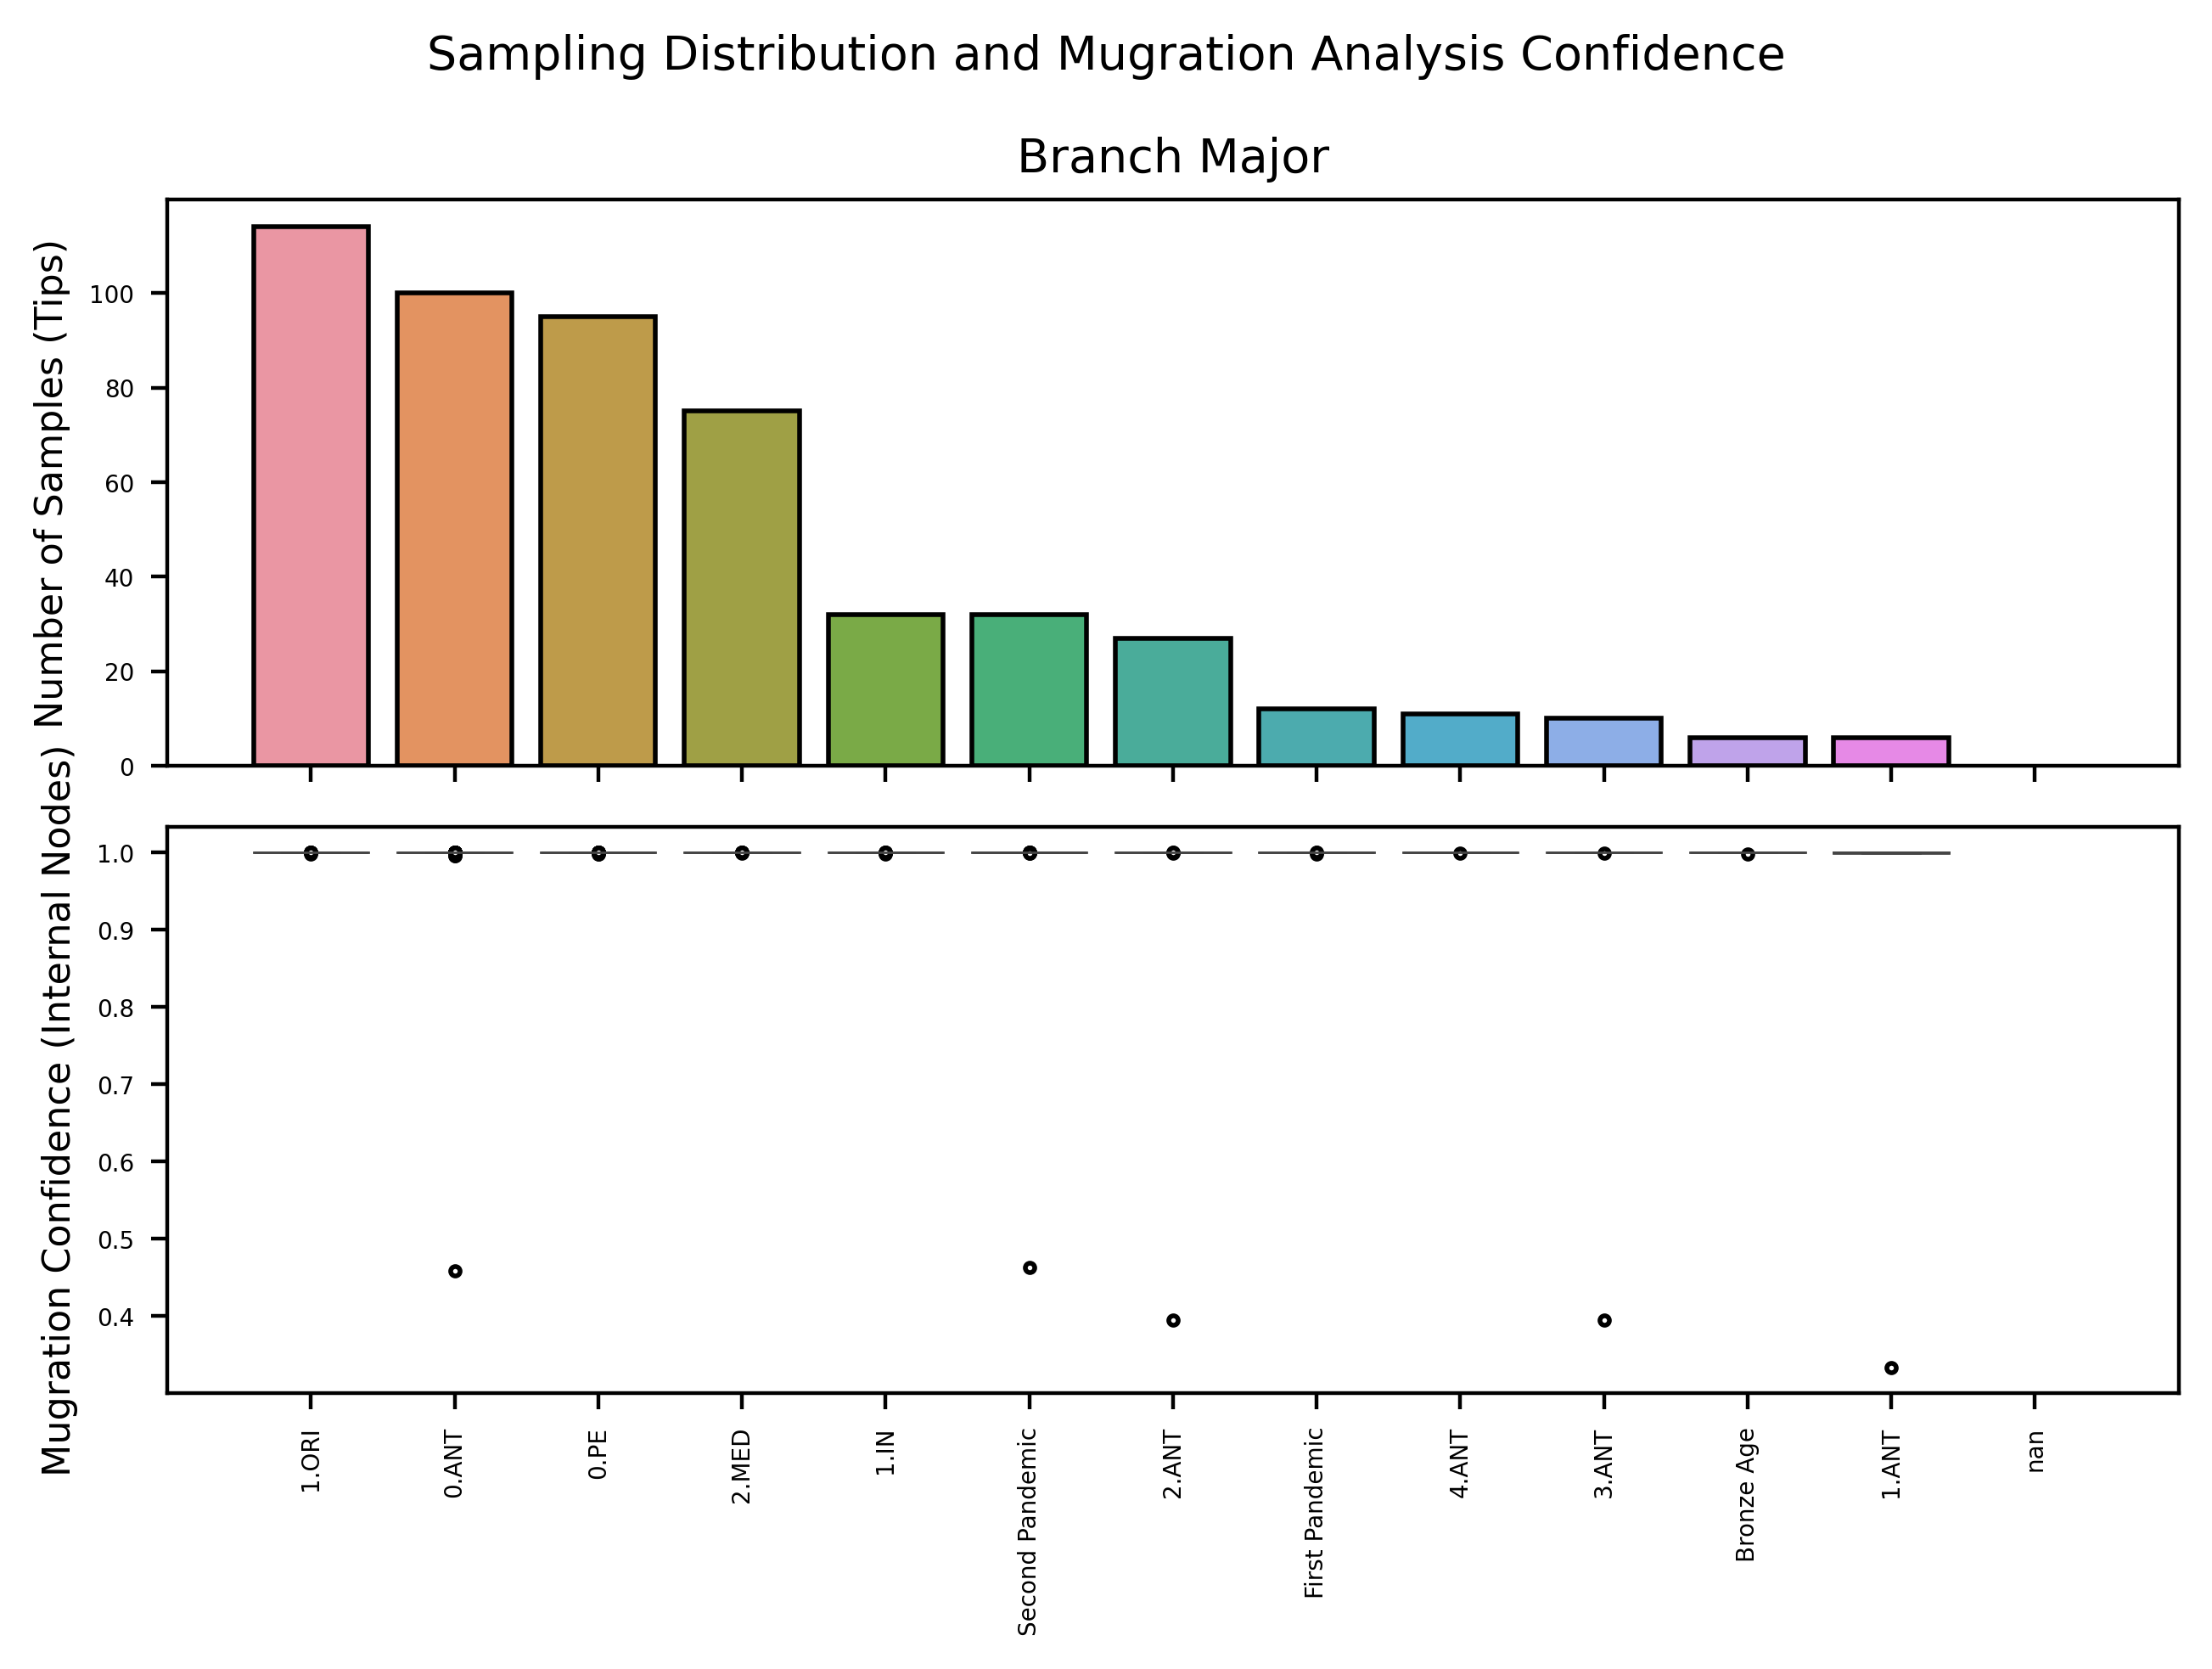

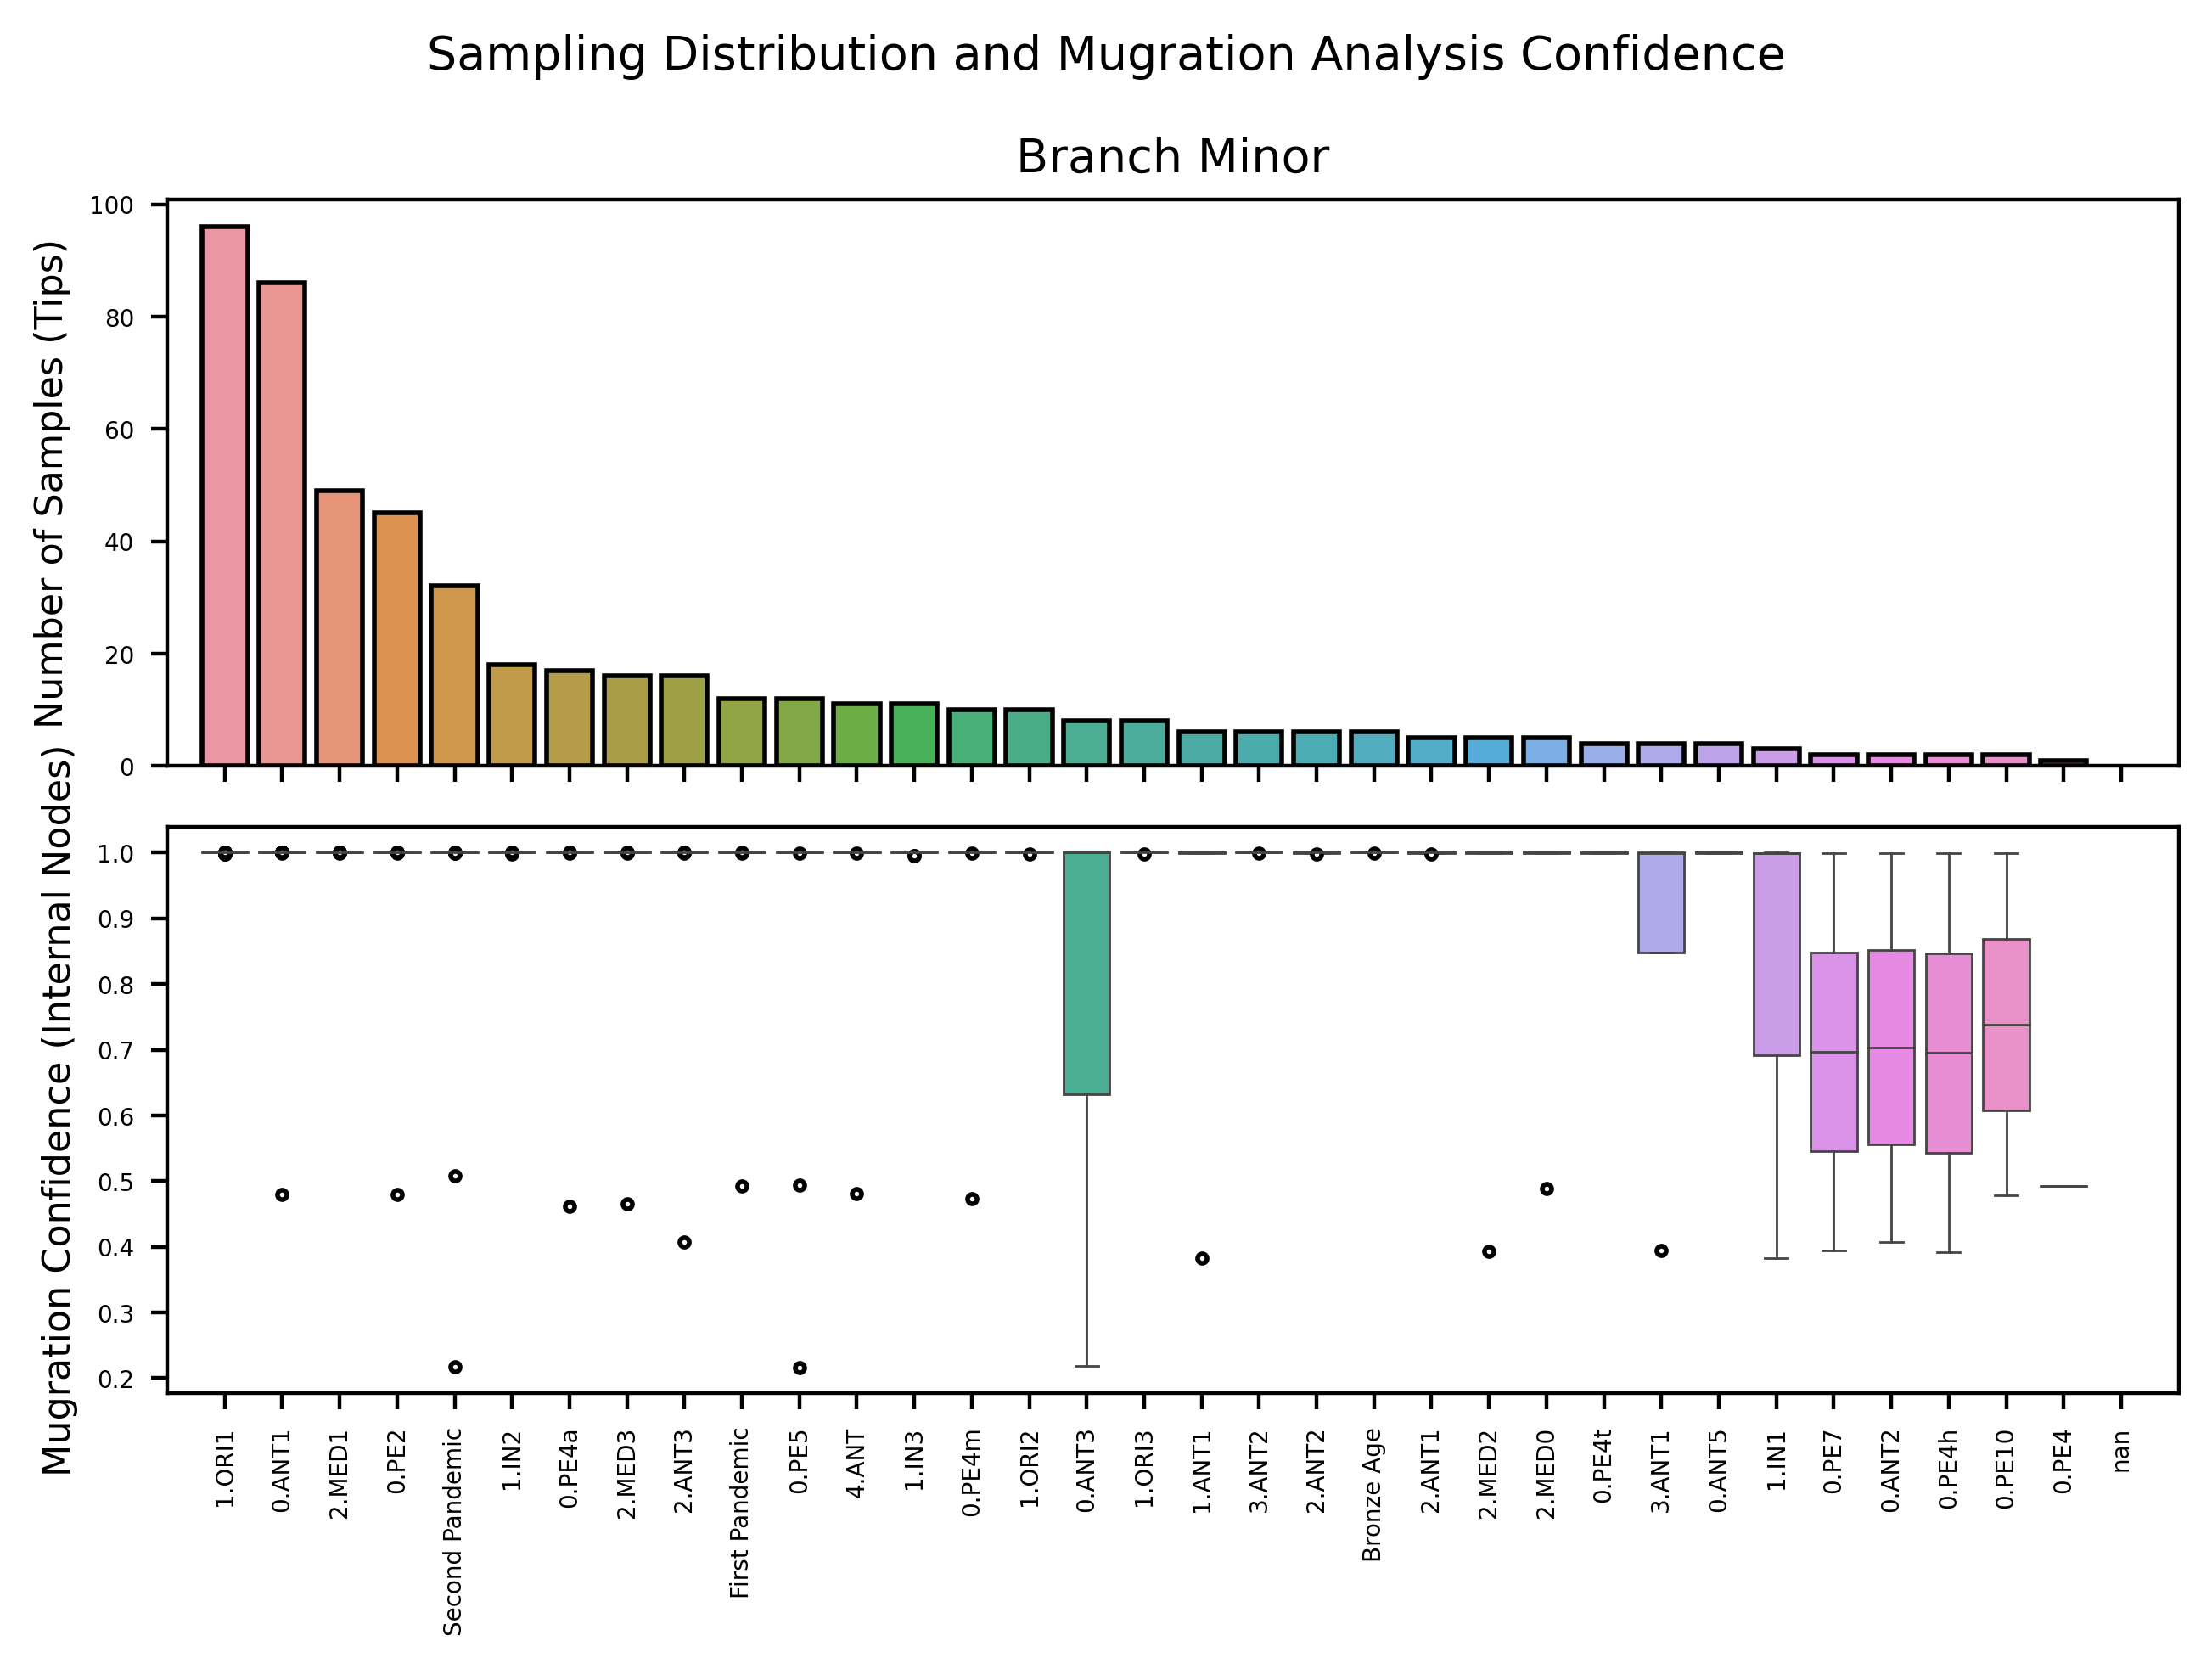

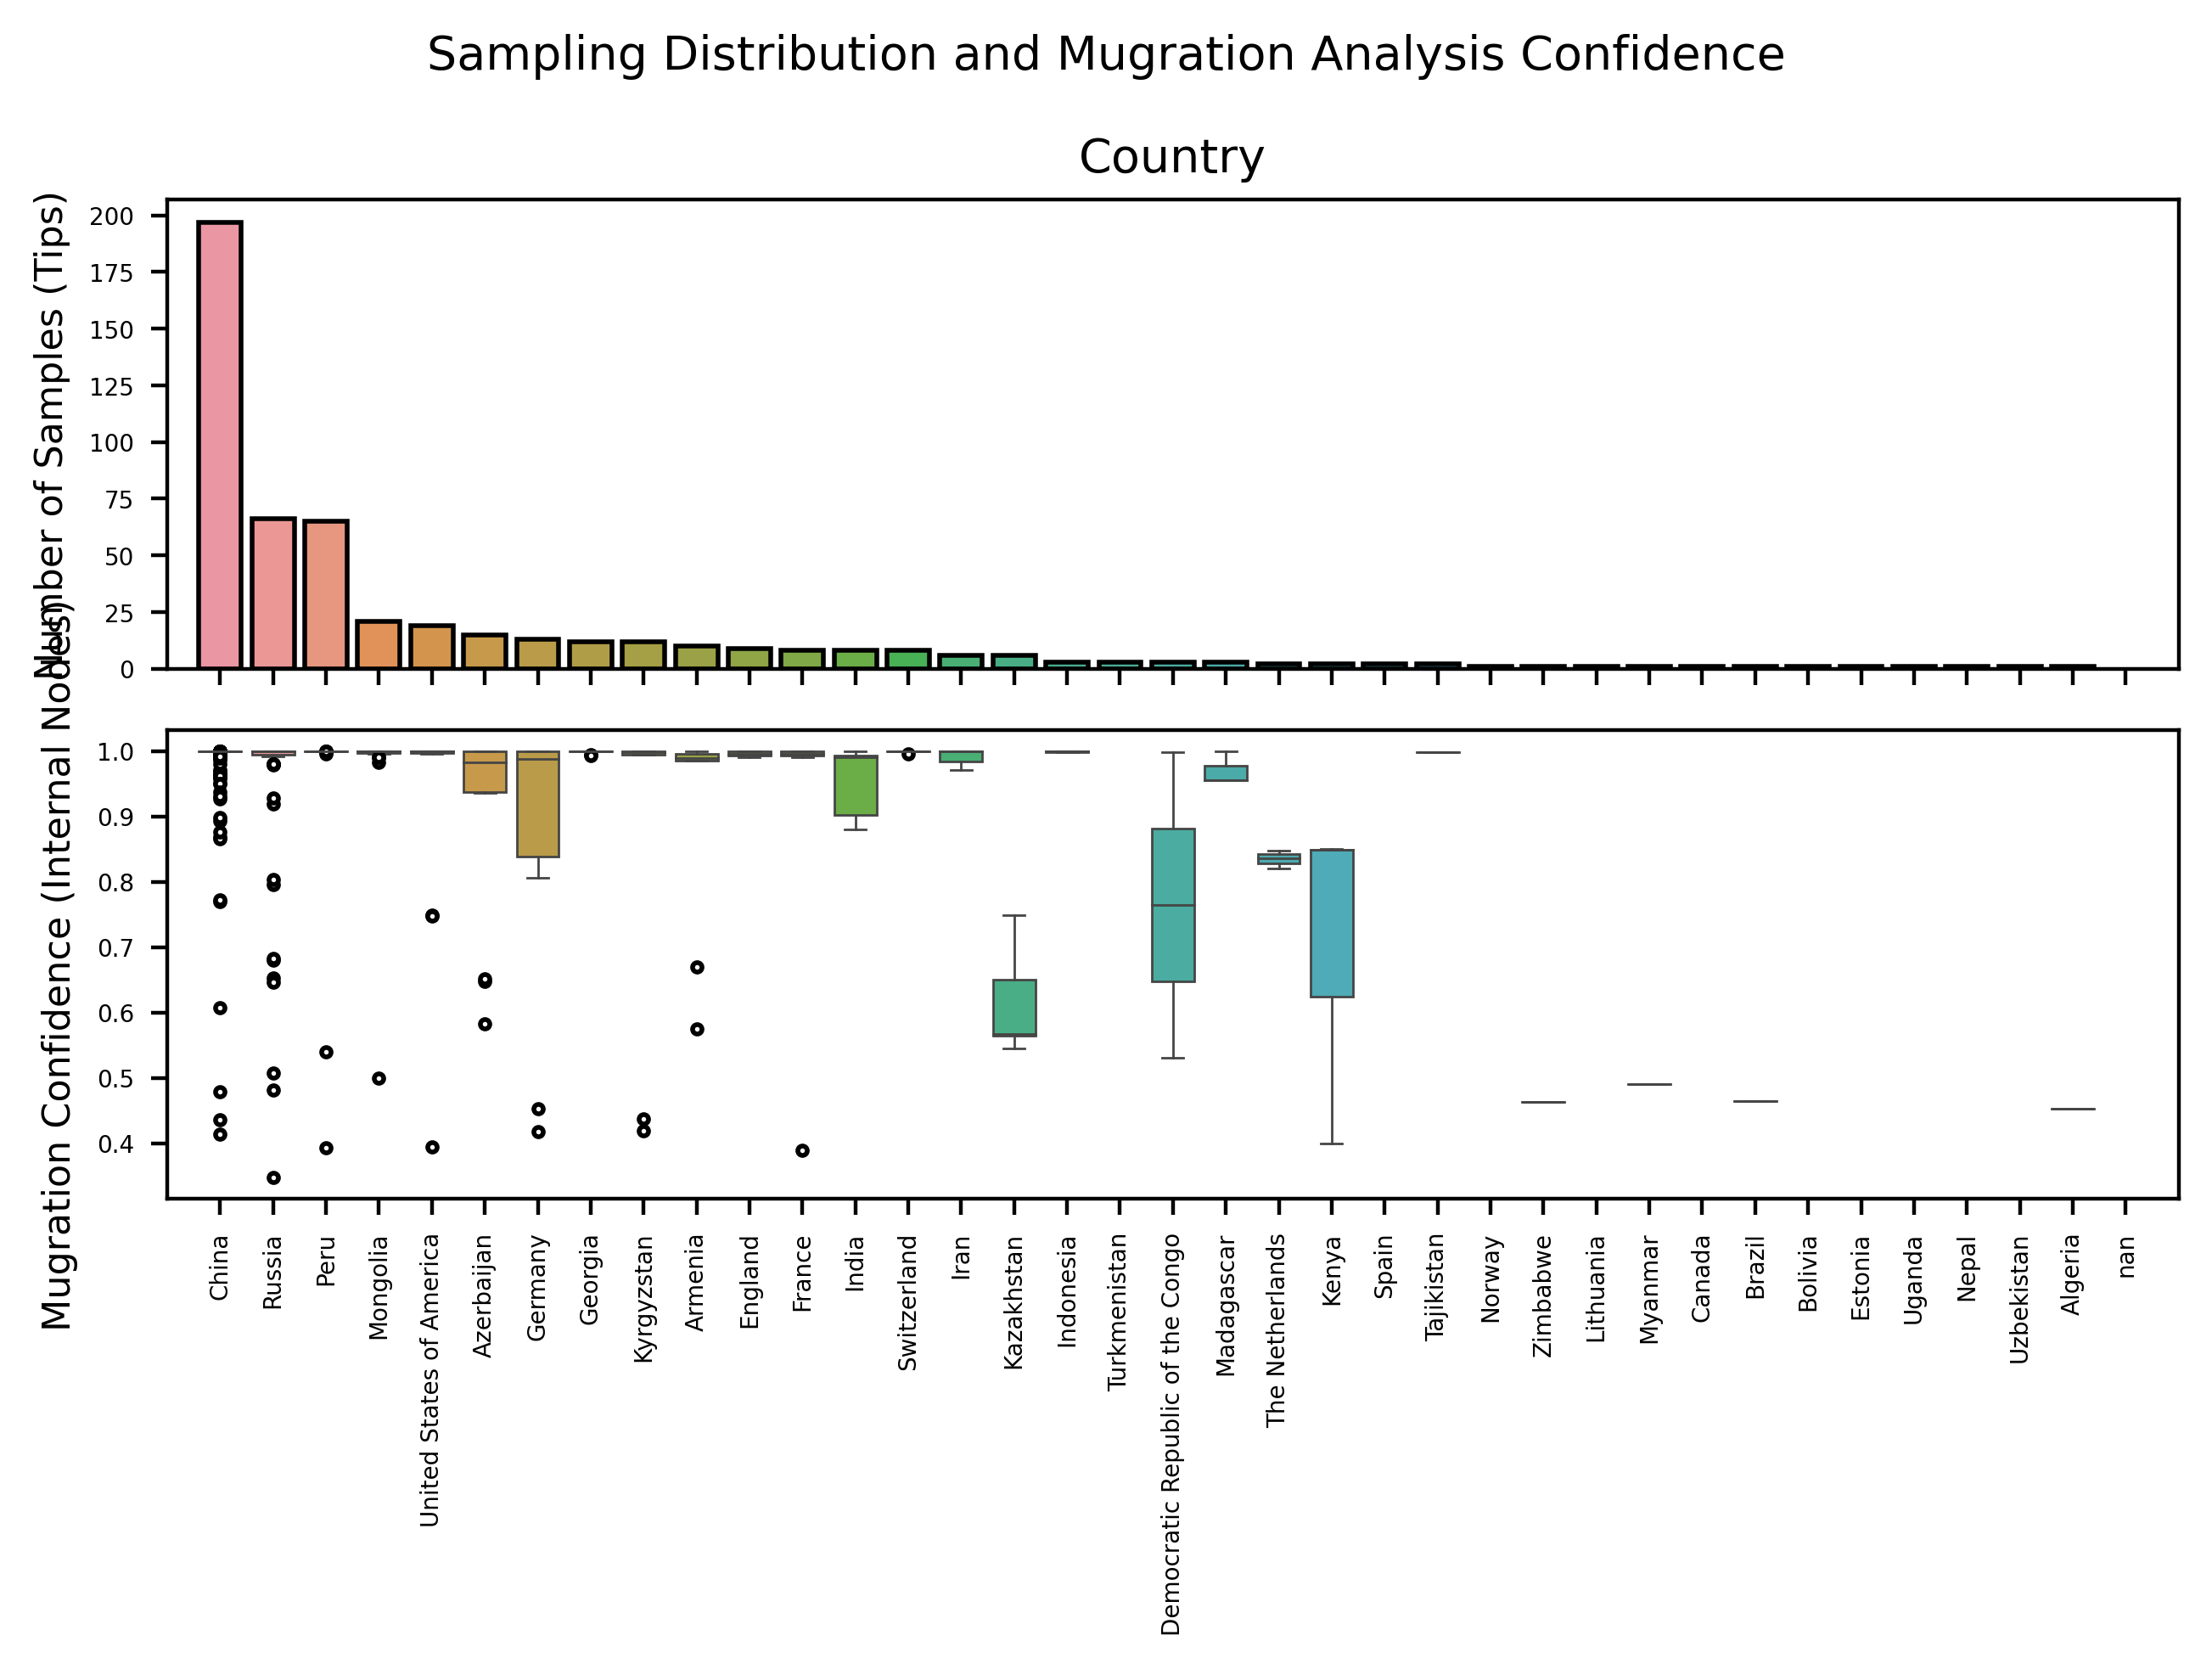

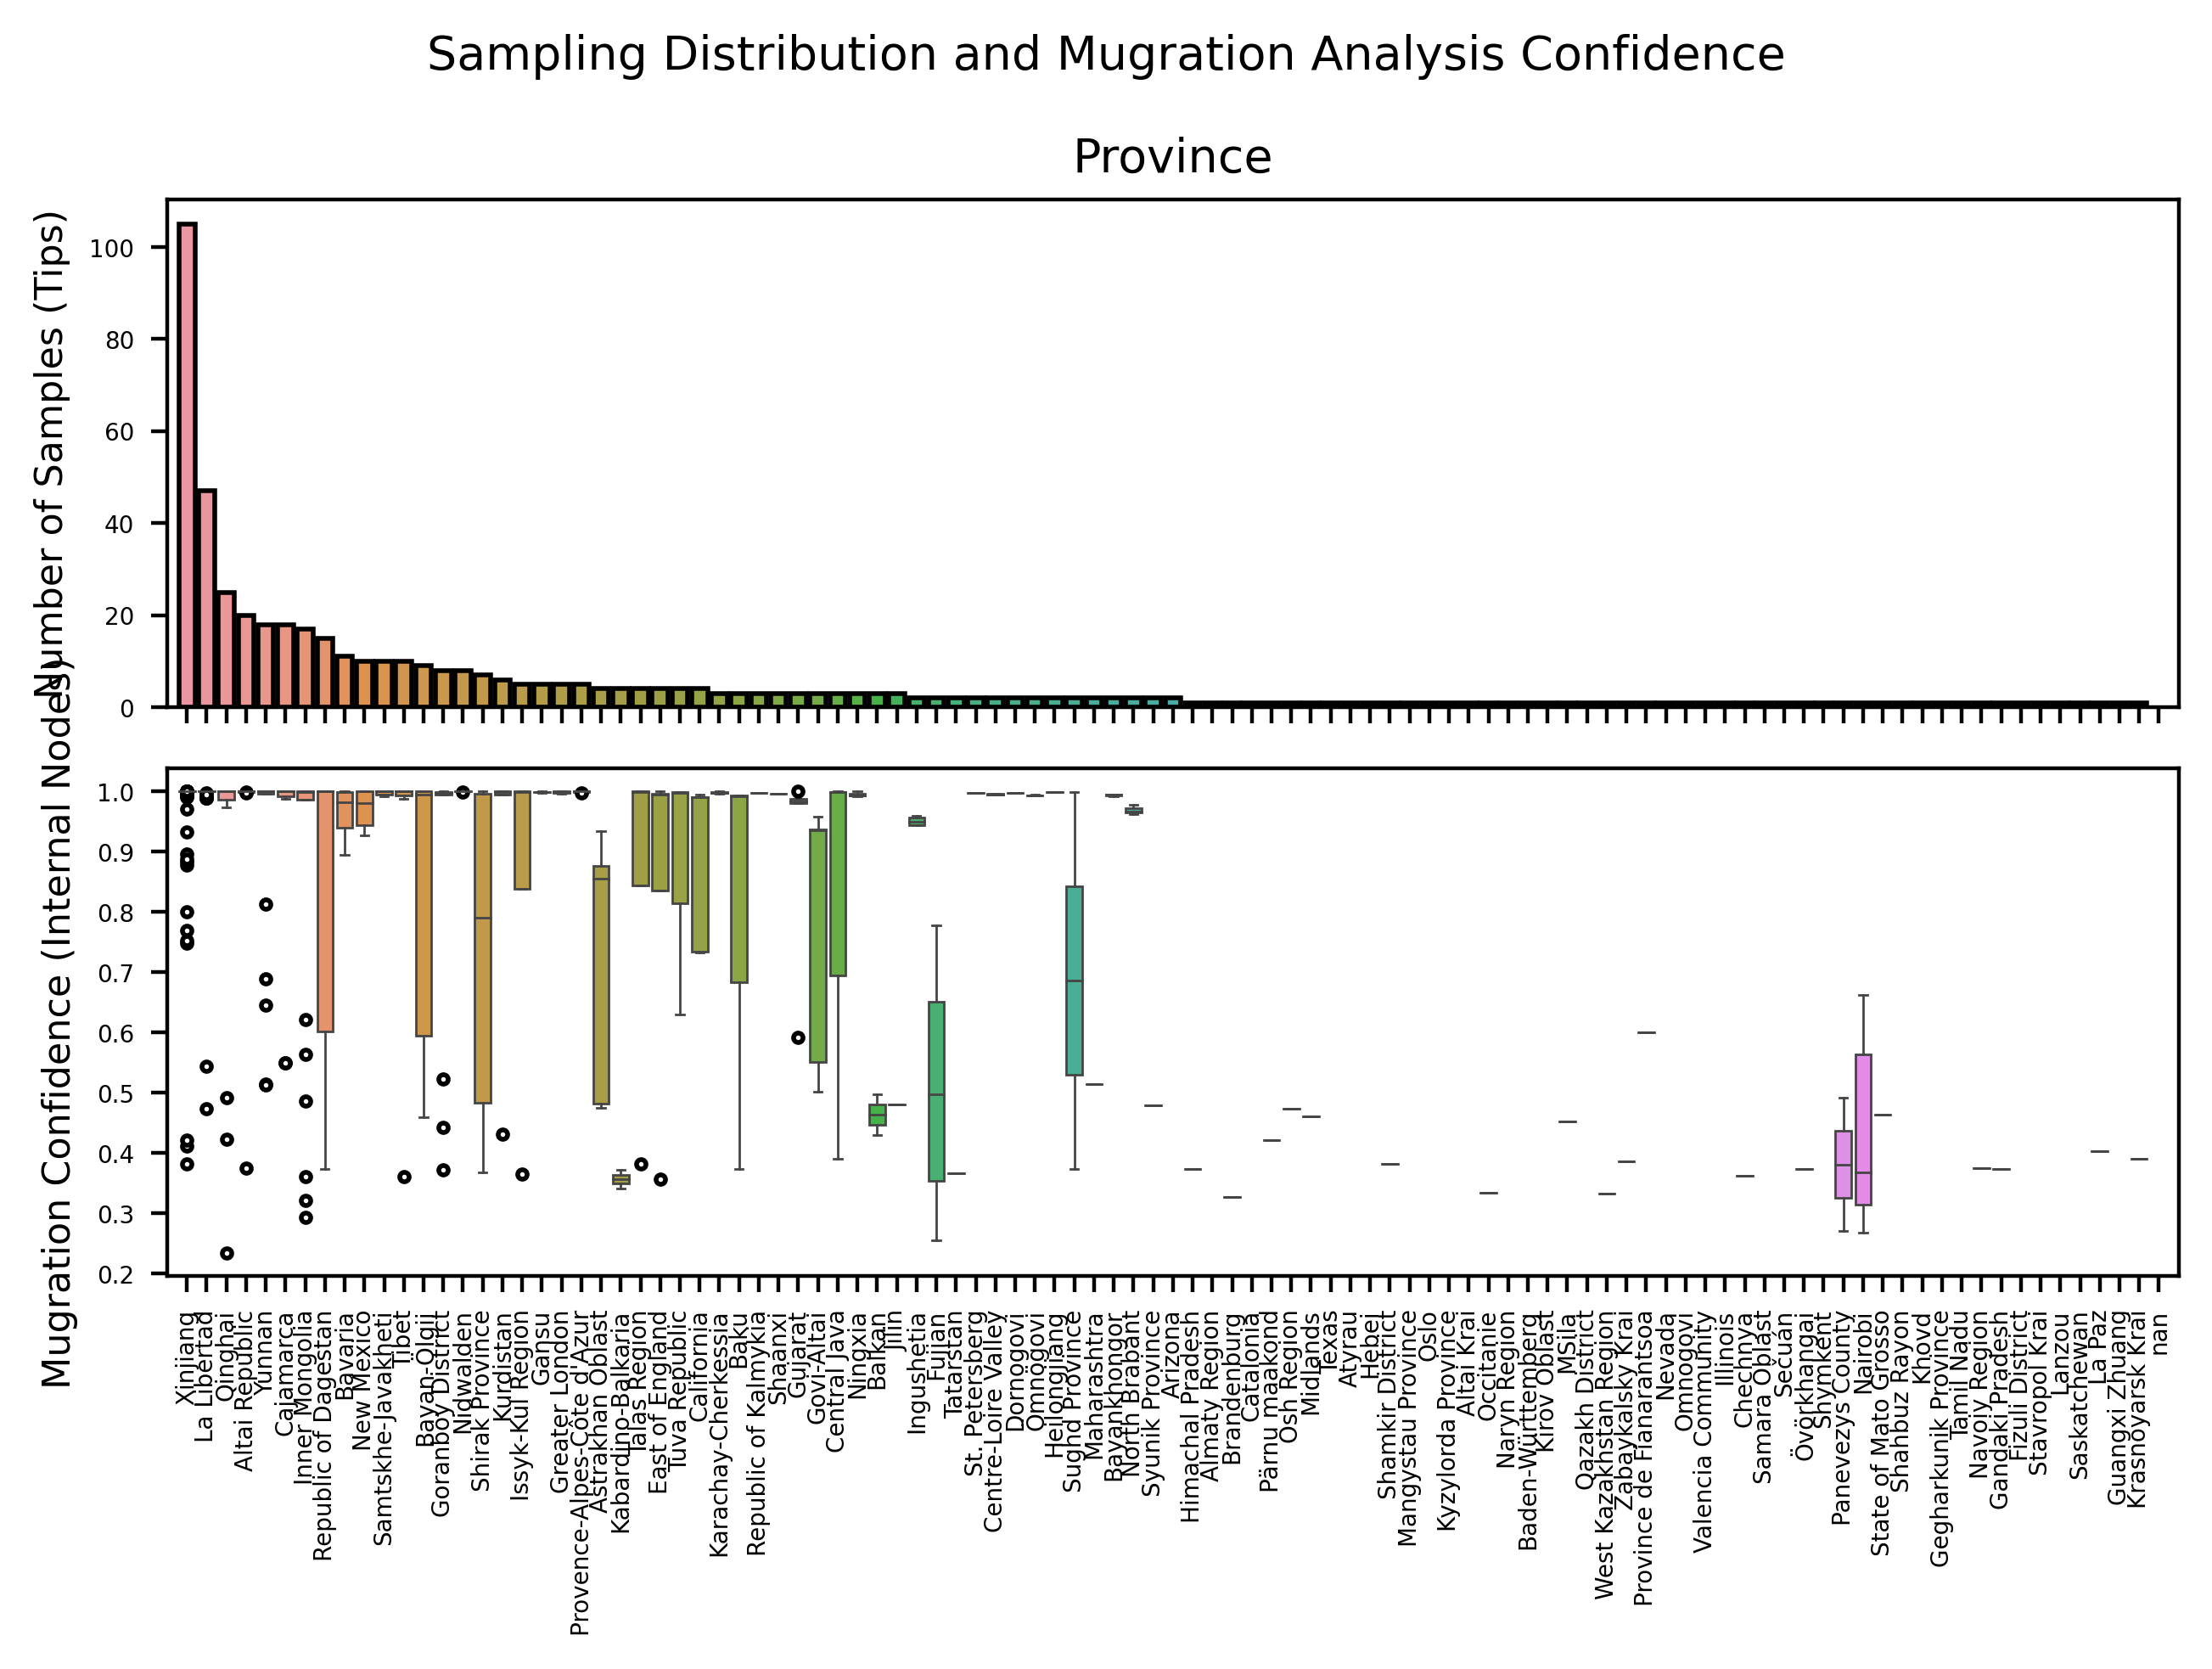

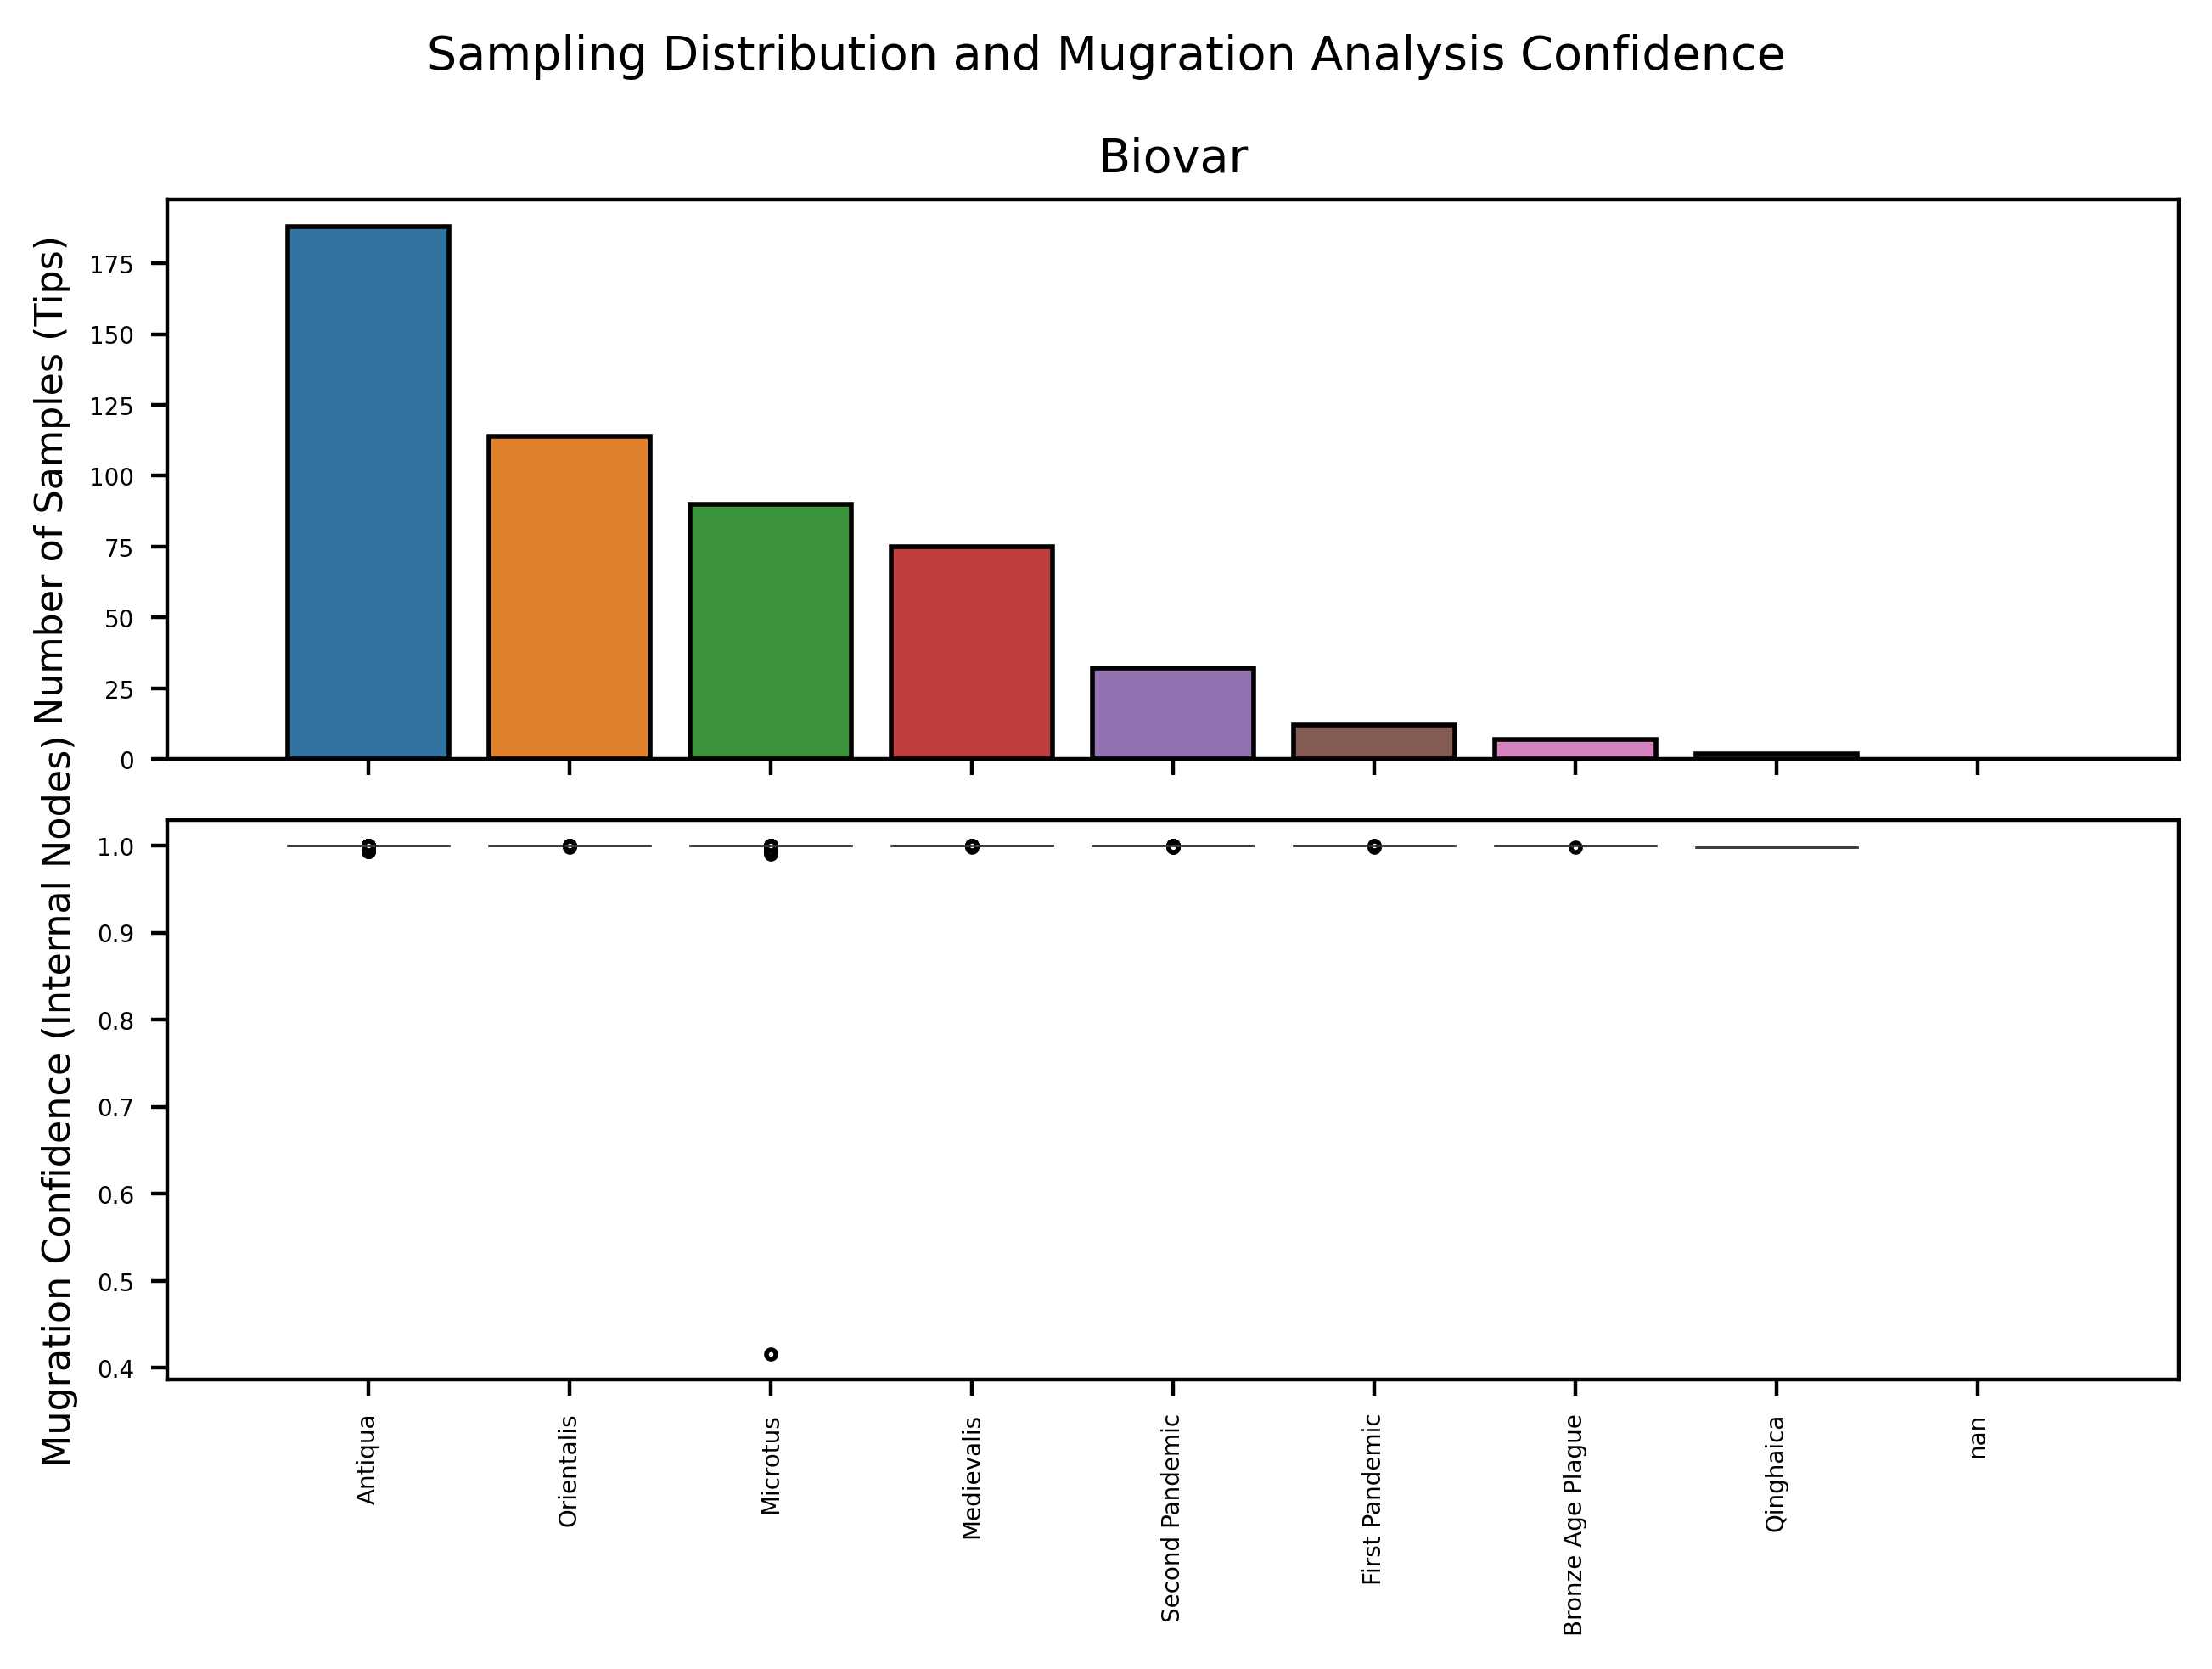

In [9]:
for attr in ATTRIBUTE_LIST:
    fig, (ax1, ax2) = plt.subplots(2, 
                               sharex=False, 
                               gridspec_kw={'hspace': 0},
                               figsize=figsize, 
                               dpi=dpi,
                               constrained_layout=True,
                              )
    
    # --------------------------
    # Axis 1 - Number of tips per state
    # Exclude samples with no attribute recorded
    data = tree_df[tree_df[attr] != NO_DATA_CHAR]
    label_order = list(data[attr].value_counts().index)
    label_order = [lab for lab in label_order if lab != "nan"] + ["nan"]
    sns.countplot(data=data, 
                  x=attr, 
                  #color="blue", 
                  edgecolor="black",
                  ax=ax1, 
                  order=label_order)
    plt.setp(ax1.get_xticklabels(), visible=False)
    xticklabels = [item.get_text() for item in ax1.get_xticklabels()]
    ax1.set_xticklabels(xticklabels, rotation = 90, ha="right")
    ax1.set_xlabel("")
    ax1.set_ylabel("Number of Samples (Tips)")
    ax1.set_xlim(-1,len(label_order)) 
    ax1.set_title(attr.replace("_"," "))
    
    # --------------------------
    # Axis 2 - Mugration Confidence
    # Exclude nodes that are terminals (ie. branch support is grey)
    data = tree_df[tree_df["Branch_Support_Color"] != "grey"]
    # Customize outlier style
    flierprops = dict(marker='o', markerfacecolor='white', markersize=2,
                      linestyle='none', markeredgecolor='black')
    # Create a boxplot
    sns.boxplot(data=data, 
                  x="Mugration_" + attr, 
                  y="Mugration_" + attr + "_Confidence",
                  #color="blue", 
                  ax=ax2, 
                  order=label_order,
                  flierprops=flierprops)
    #plt.setp(ax2.get_xticklabels(), visible=False)
    xticklabels = [item.get_text() for item in ax2.get_xticklabels()]
    ax2.set_xticklabels(xticklabels, rotation = 90, ha="center")
    #ax2.axhline(y=MUG_CONF_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
    ax2.set_xlabel("")
    ax2.set_ylabel("Mugration Confidence (Internal Nodes)")
    ax2.set_xlim(-1,len(label_order))
    
    fig.suptitle("Sampling Distribution and Mugration Analysis Confidence")
    
    out_path = os.path.join(outdir, SCRIPT_NAME + "_boxplot_{}.{}".format(attr.lower(), FMT)) 
    plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# 4. Plot colored trees

## Color branches on mug/div tree according to state

/opt/conda/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.


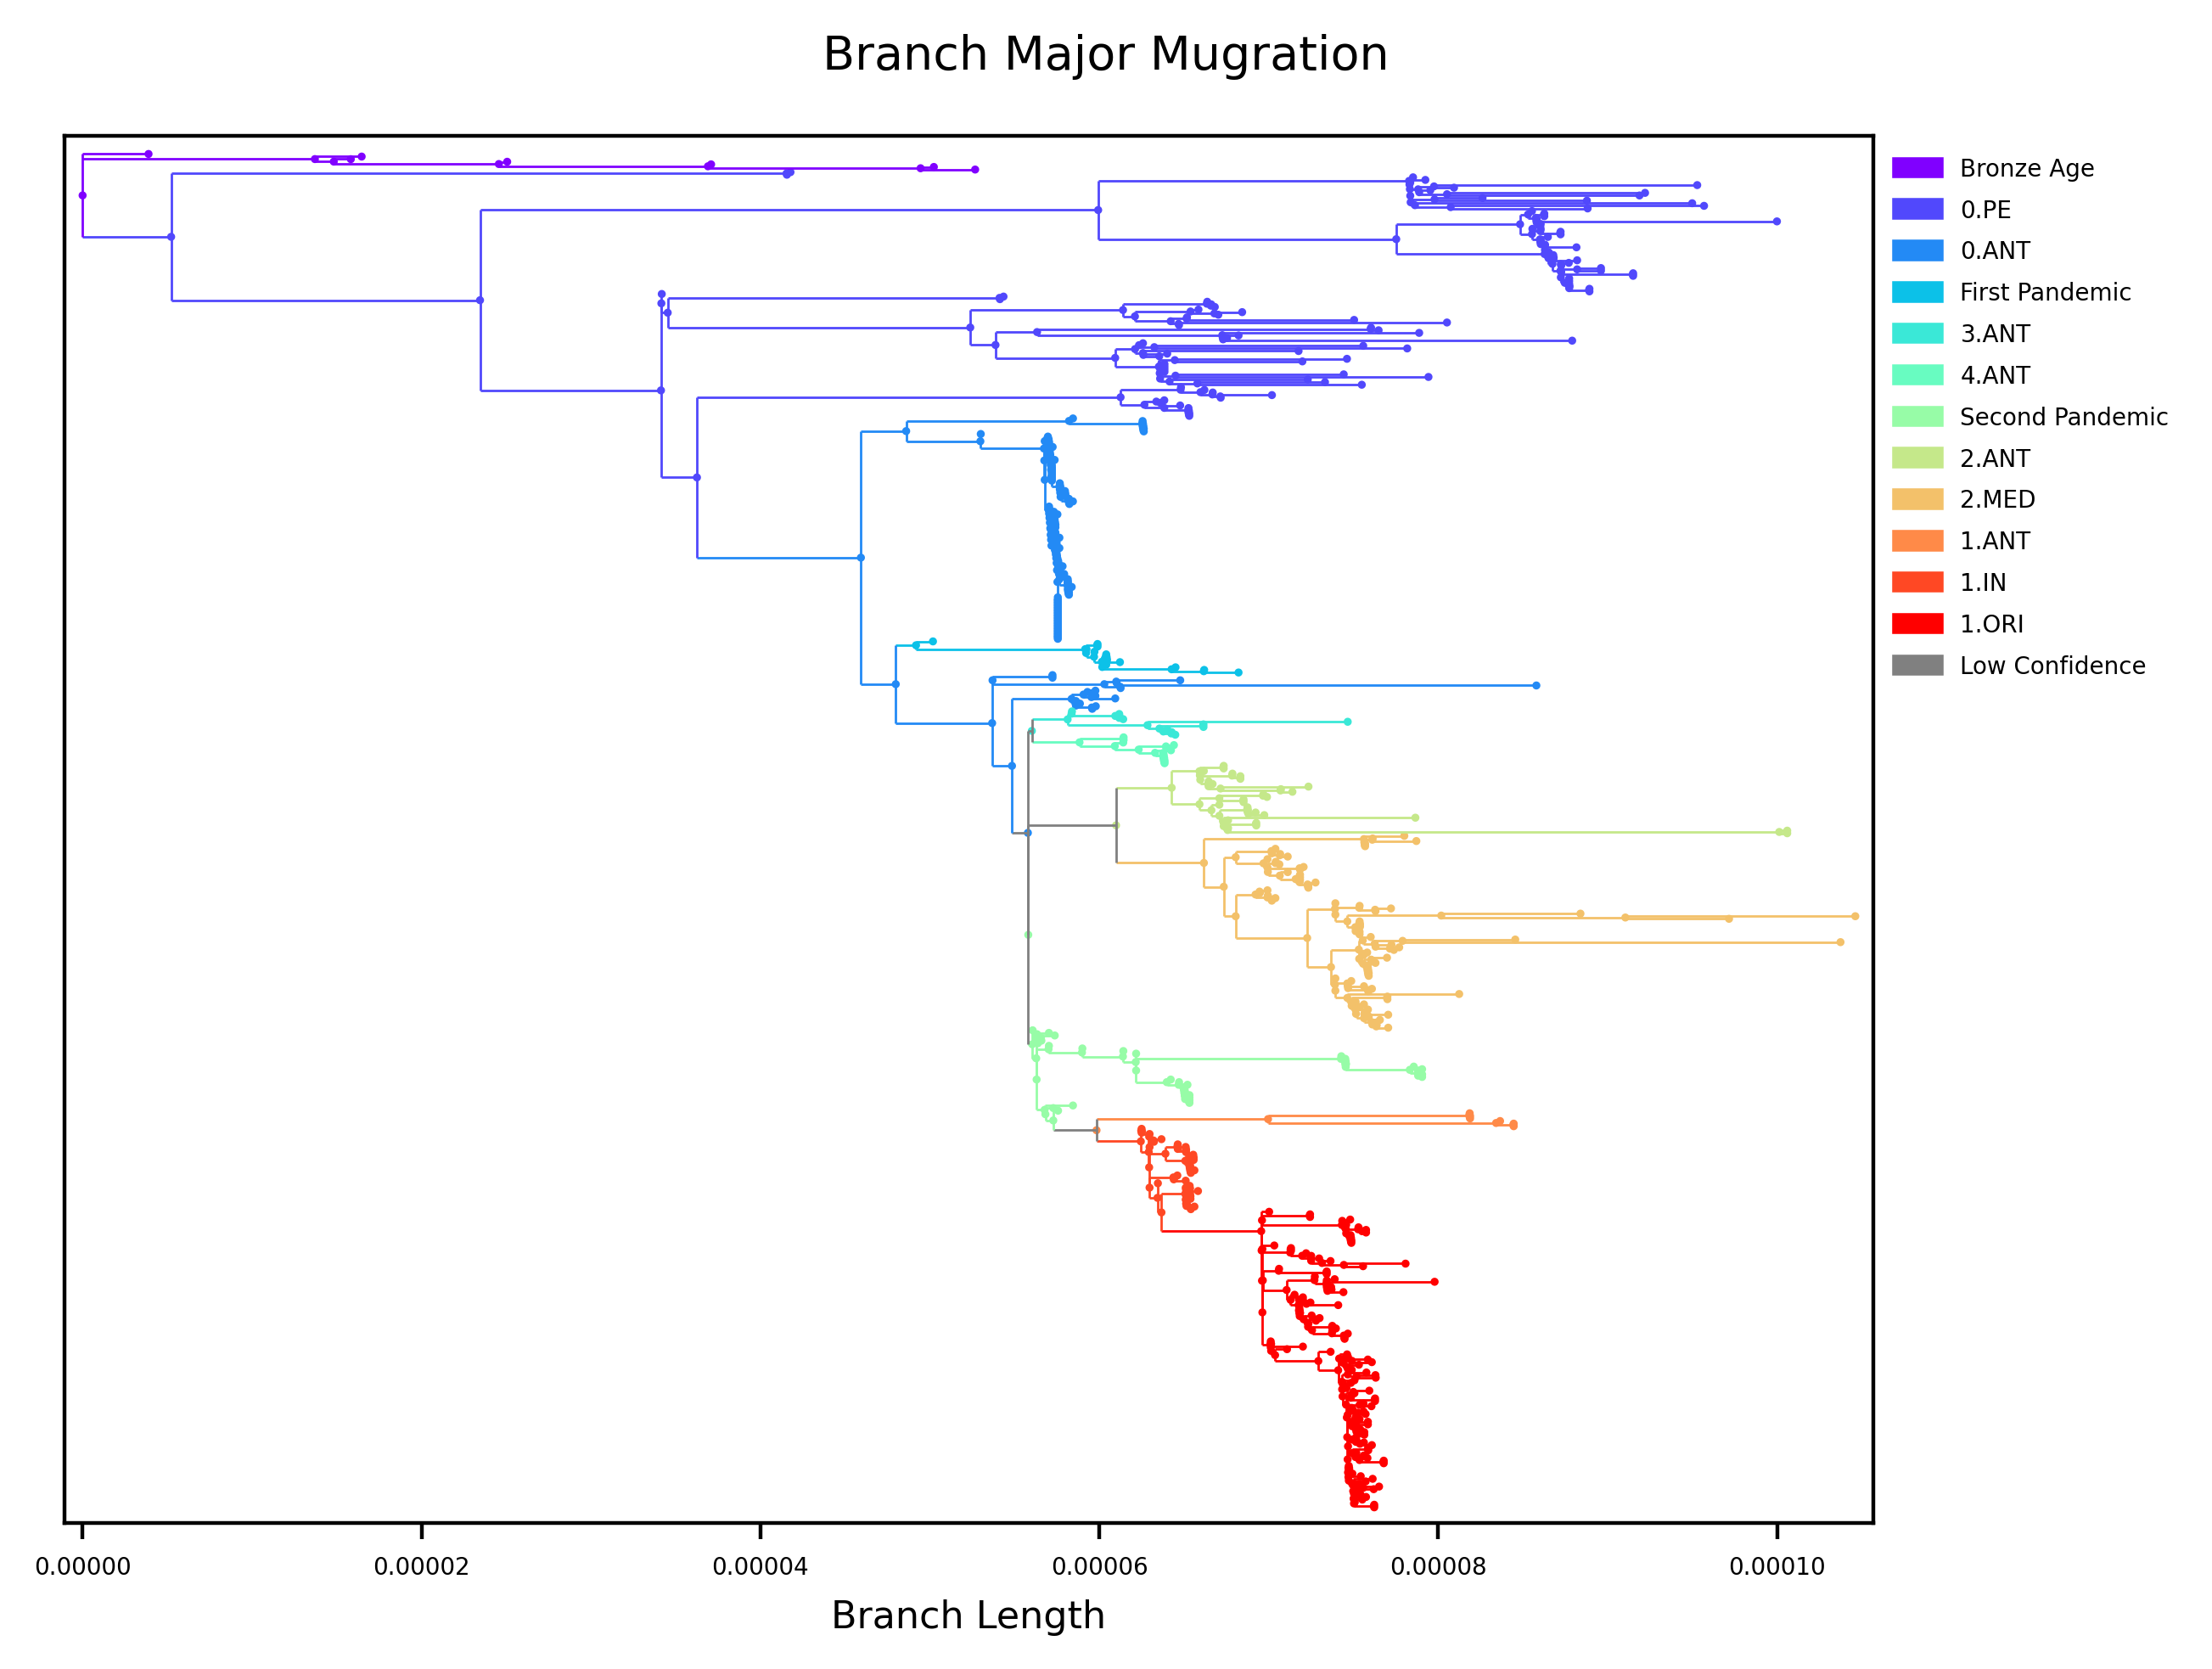

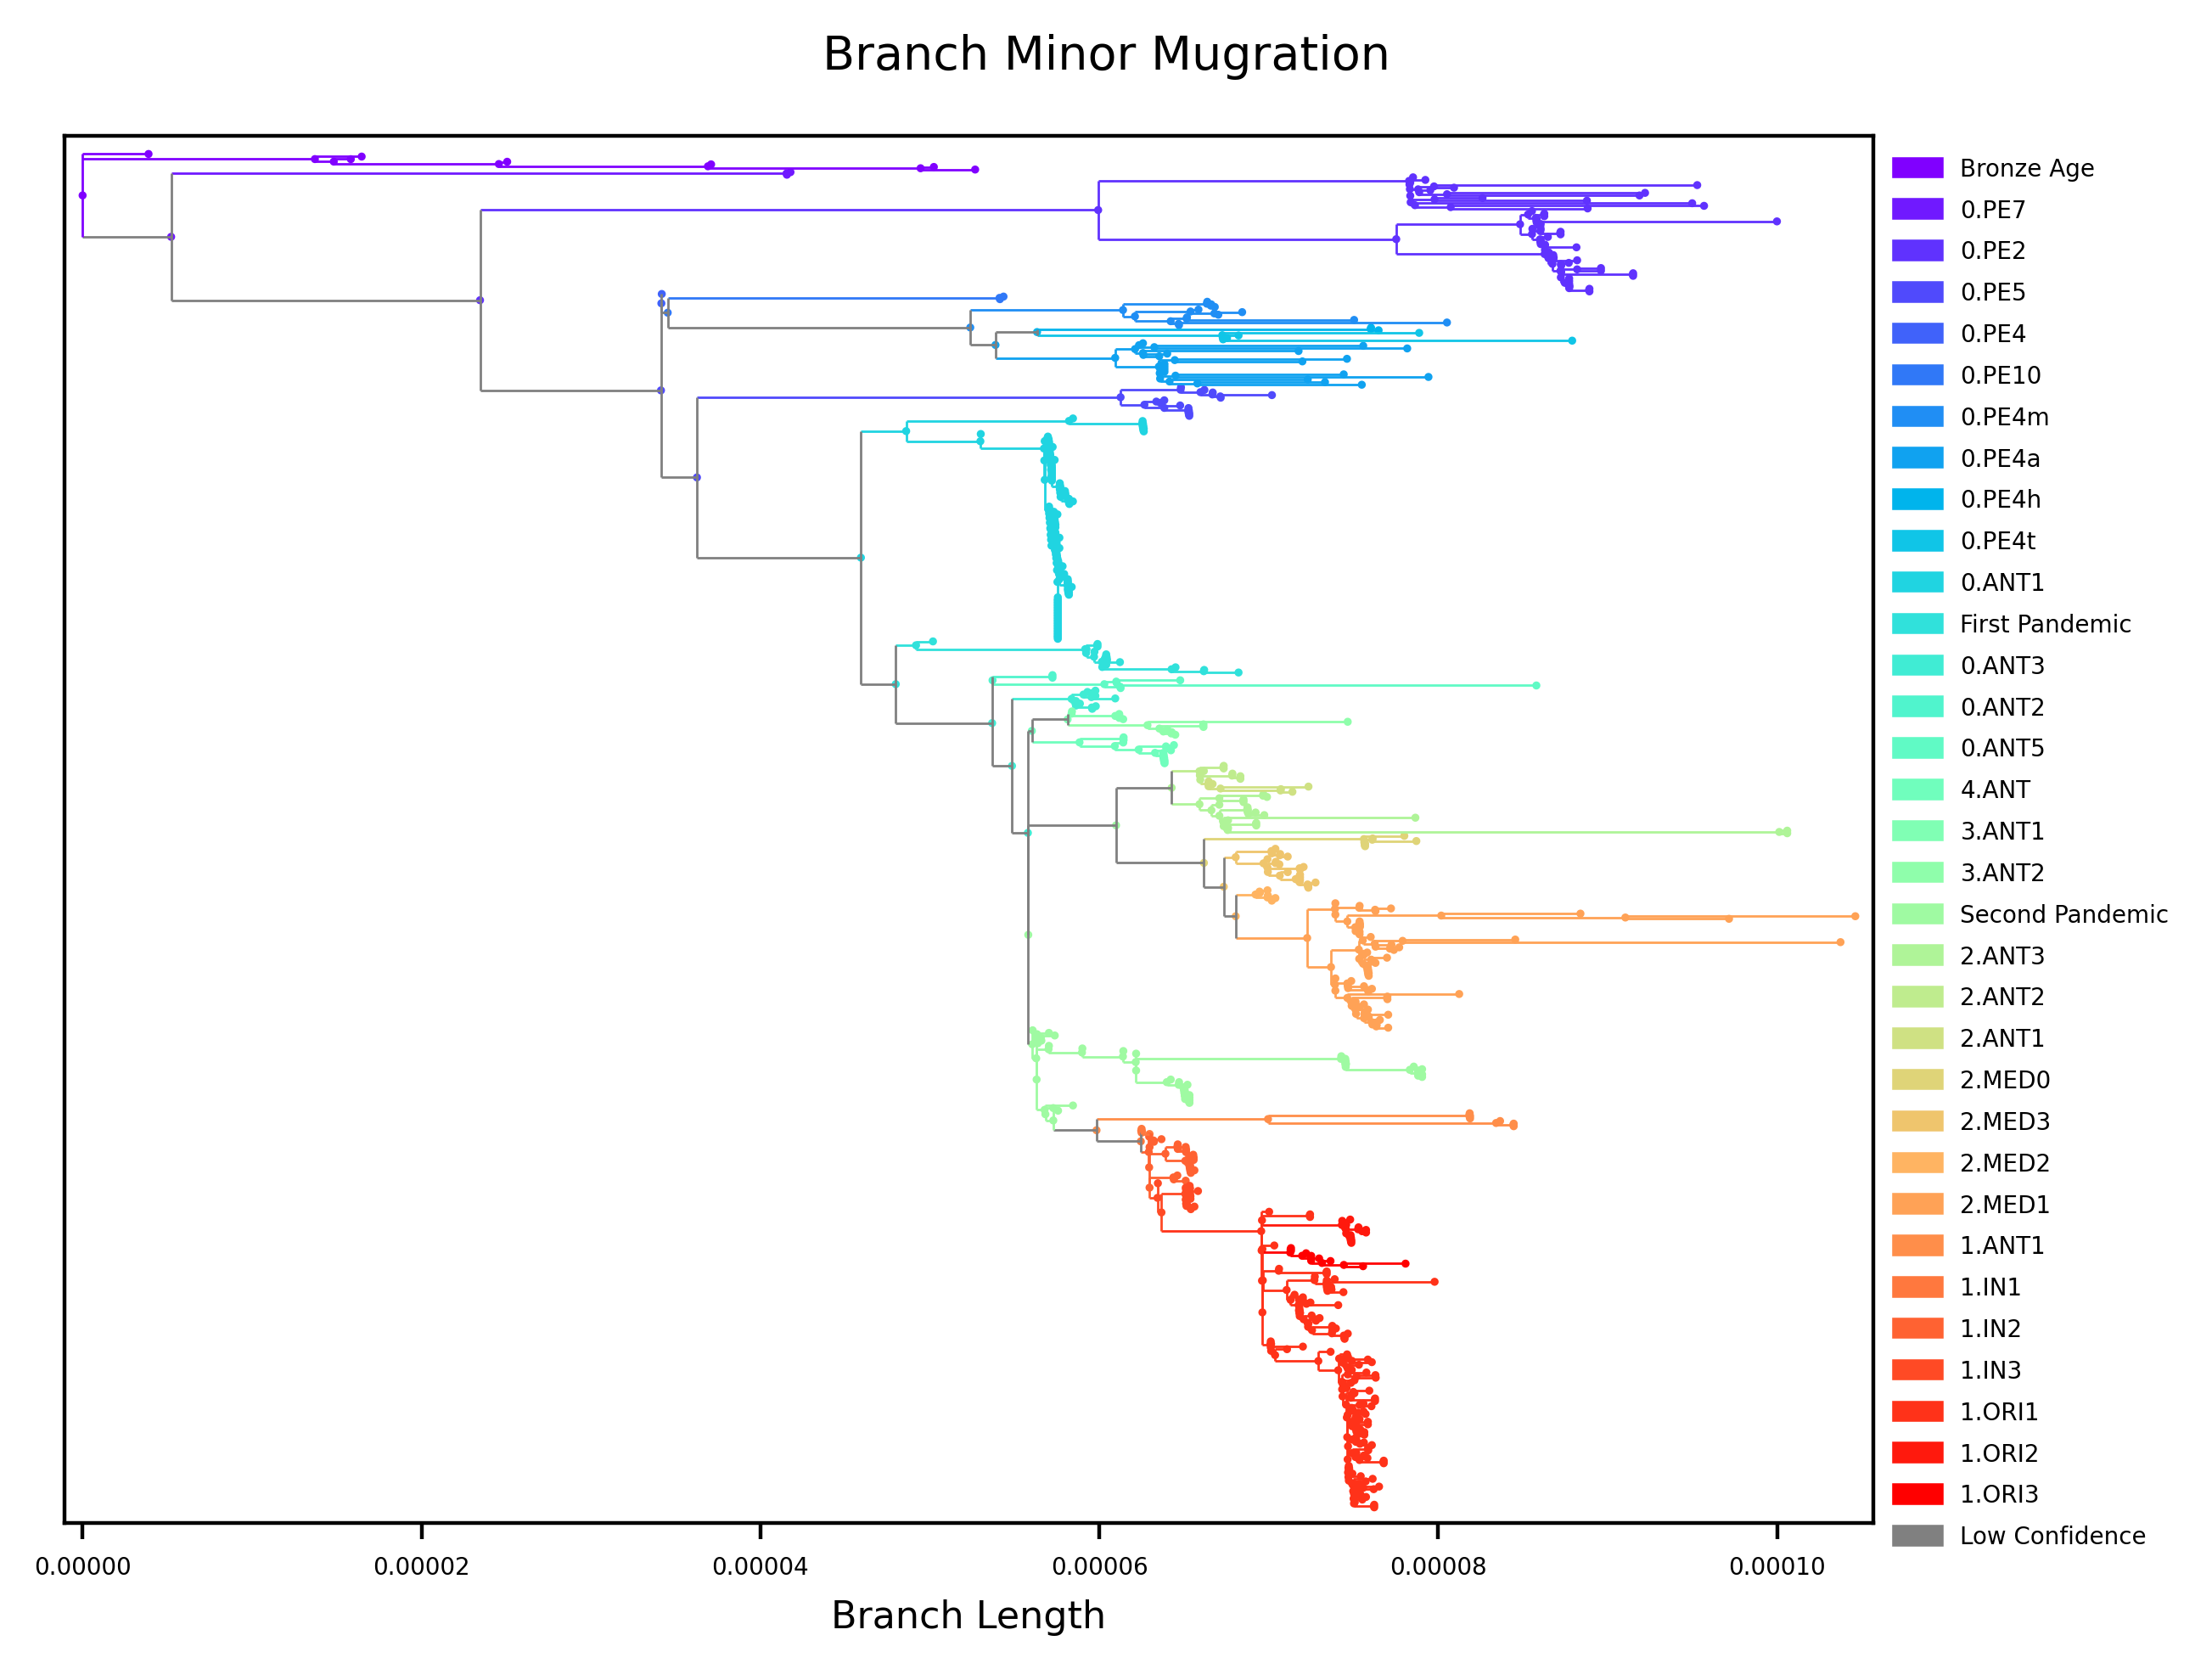

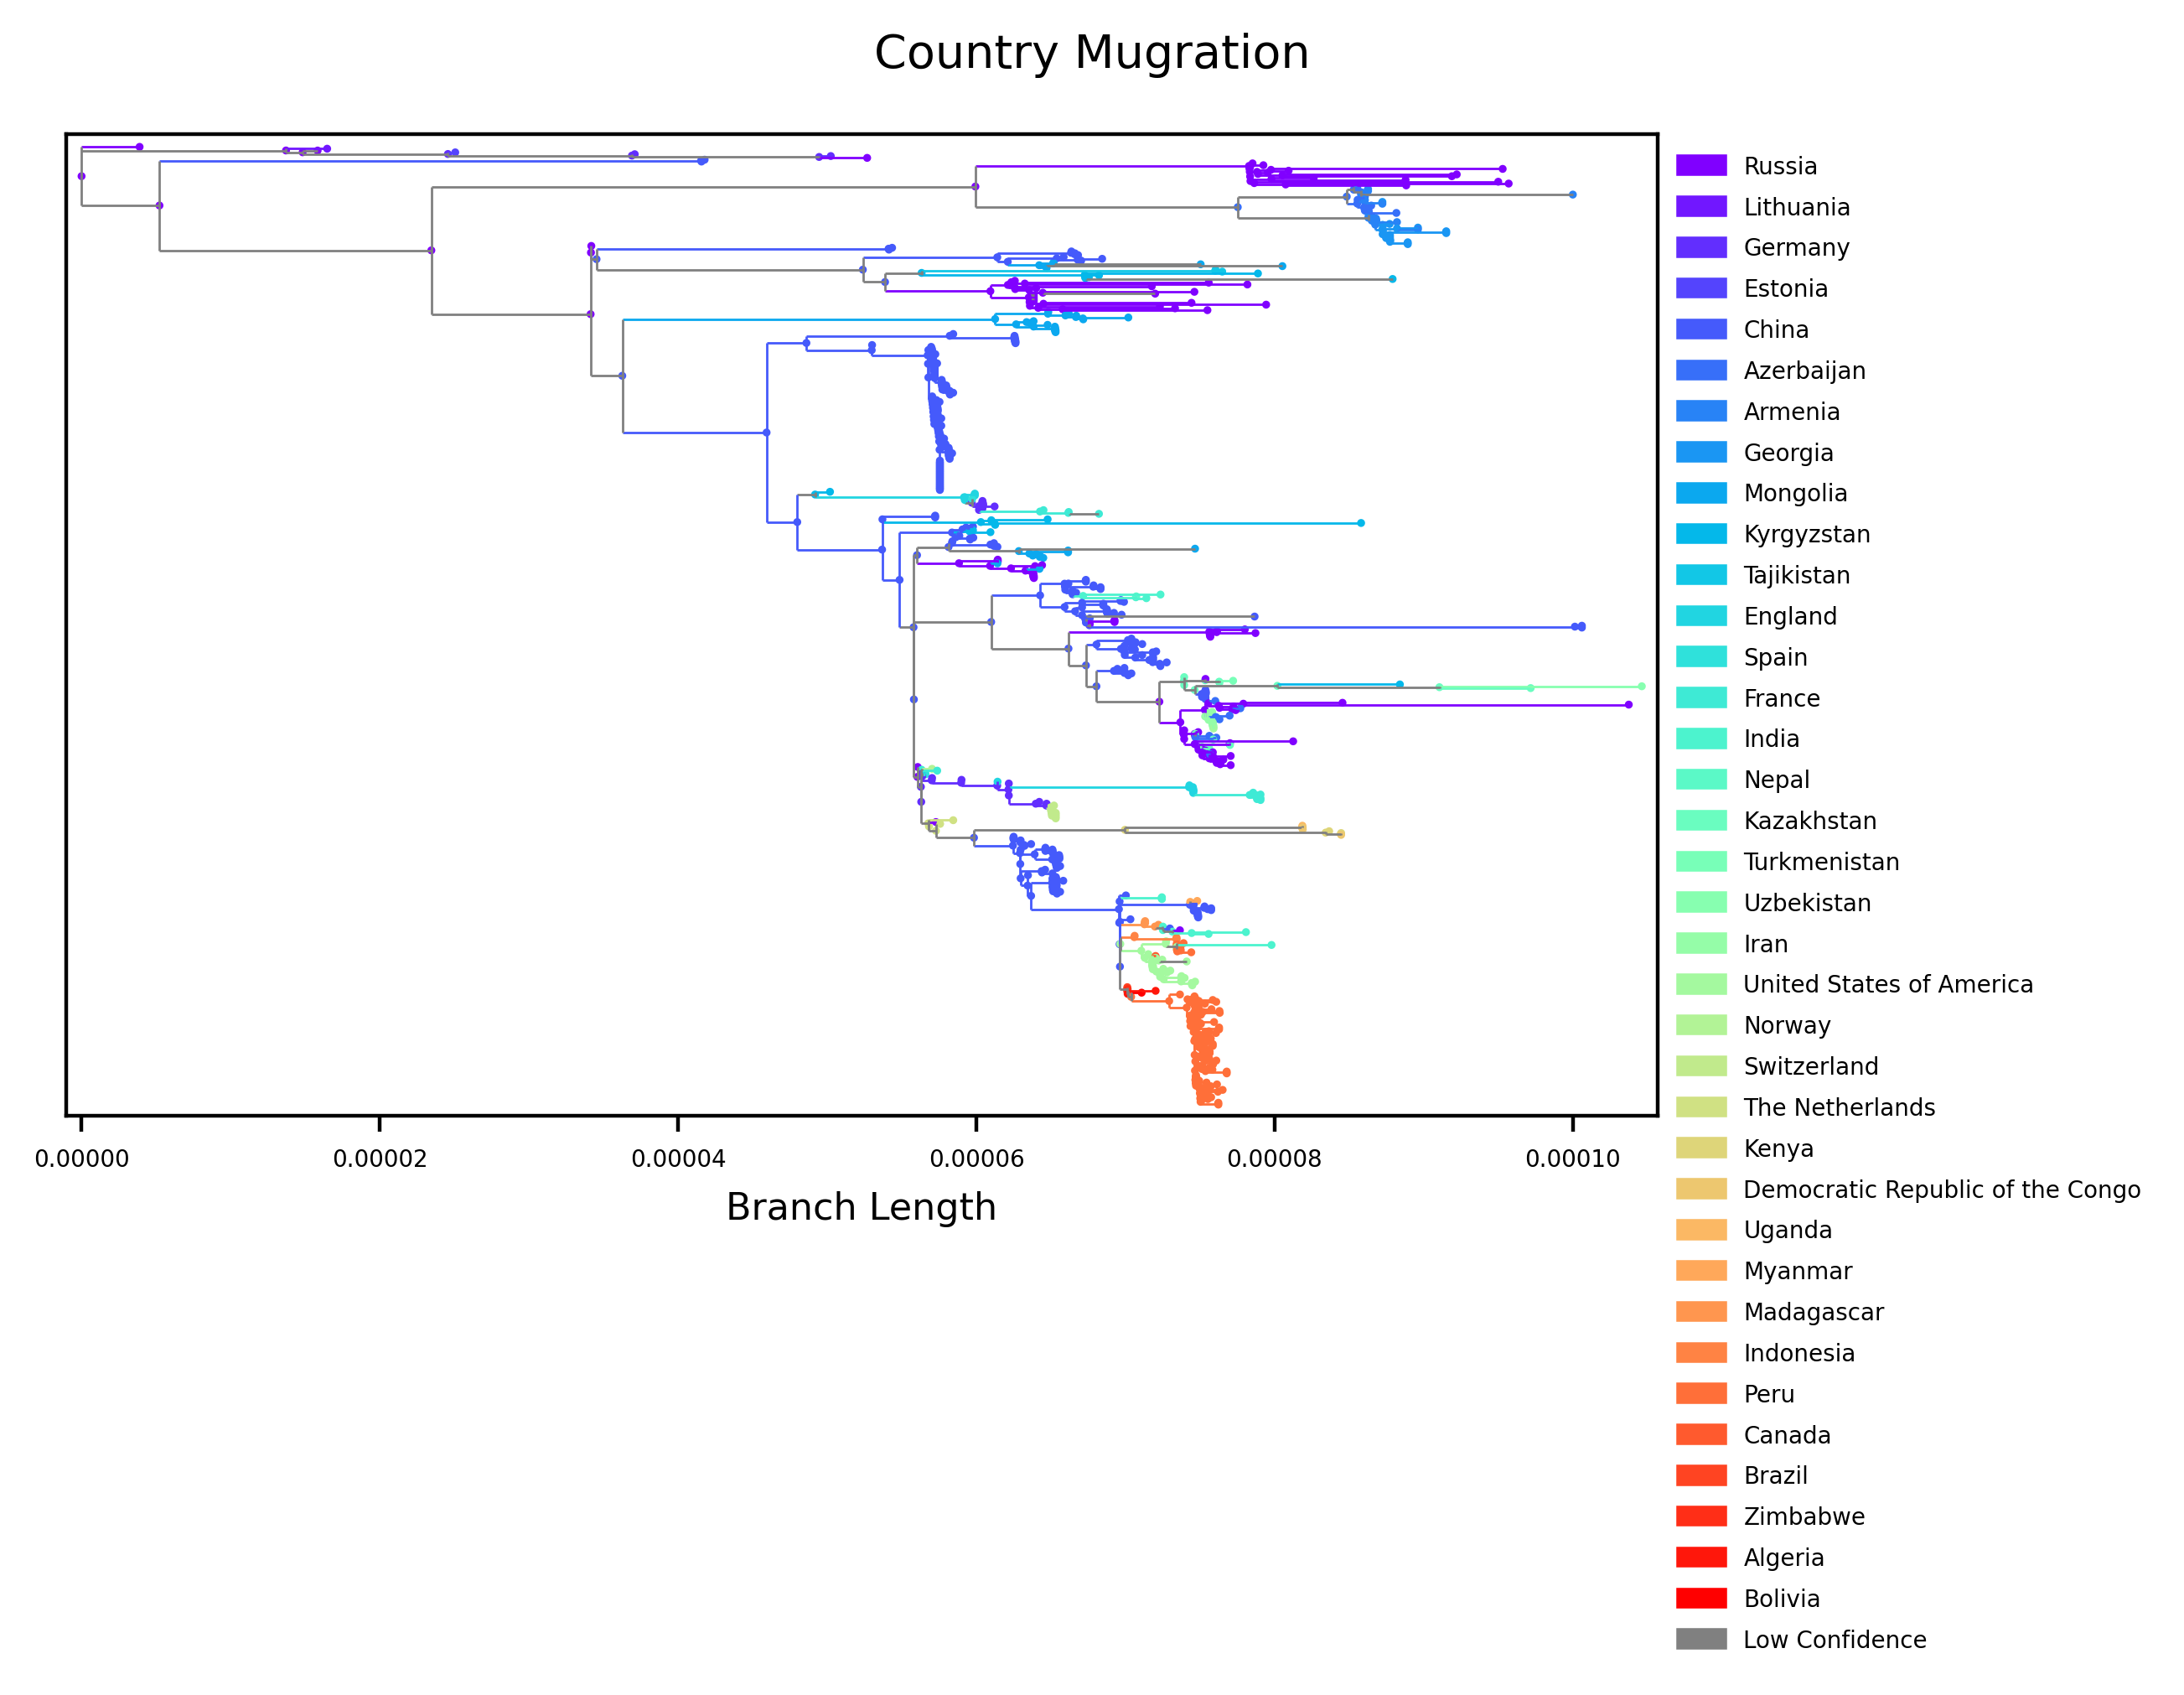

/opt/conda/envs/plague-phylogeography/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


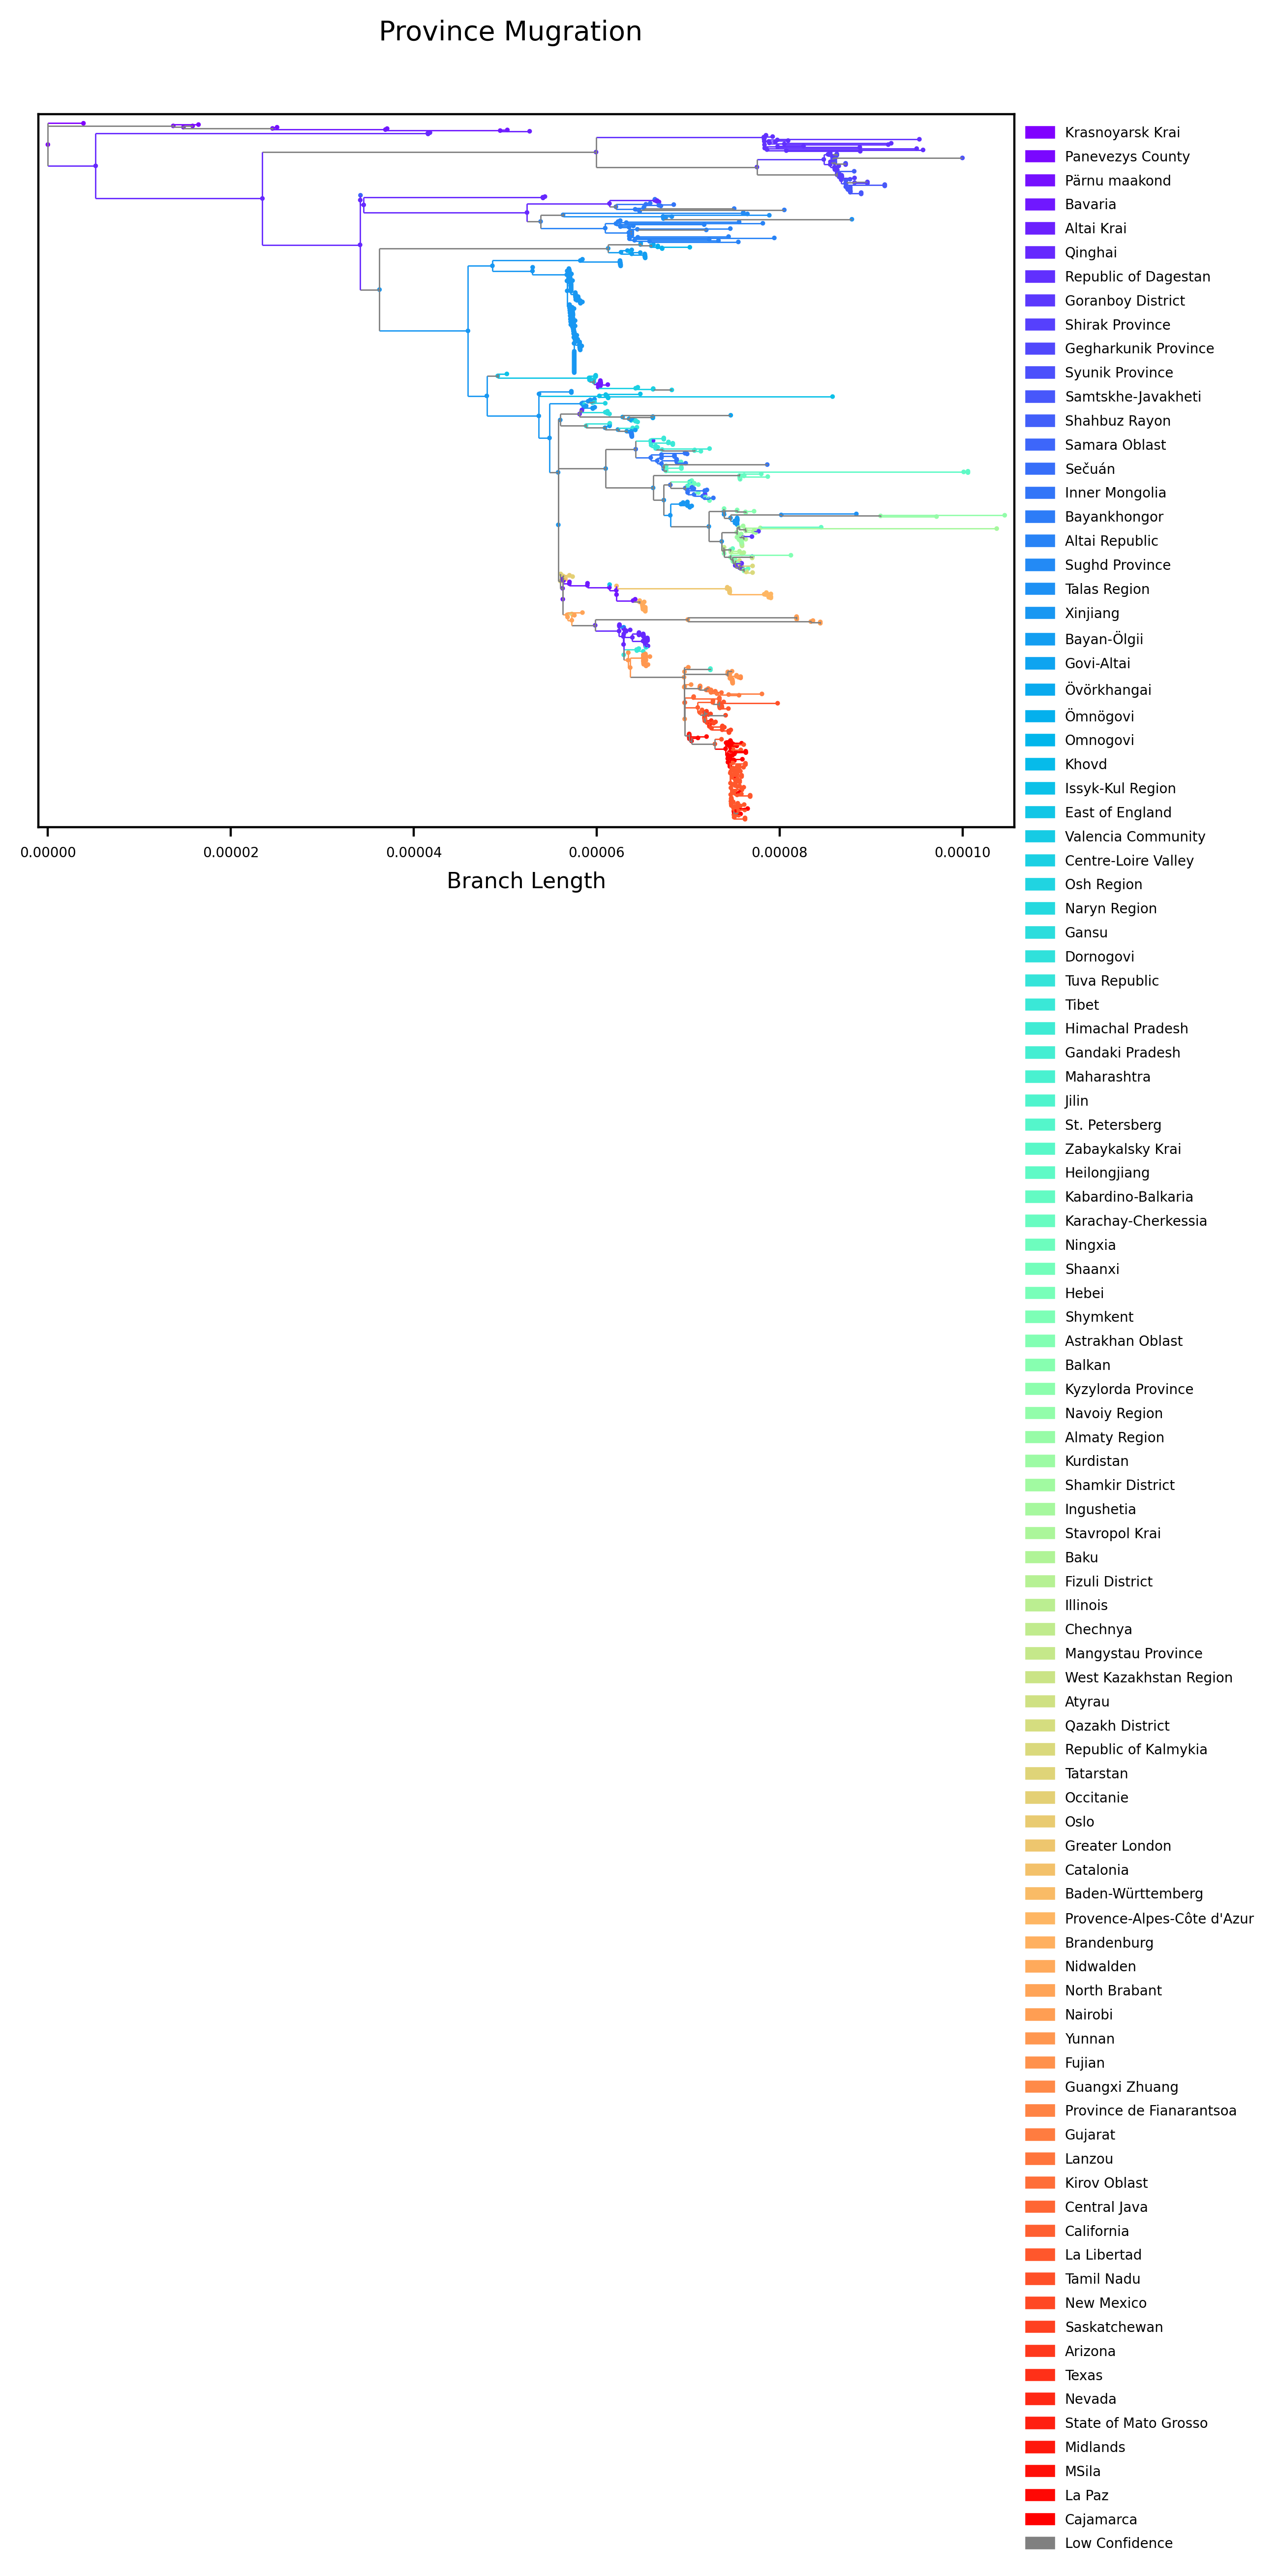

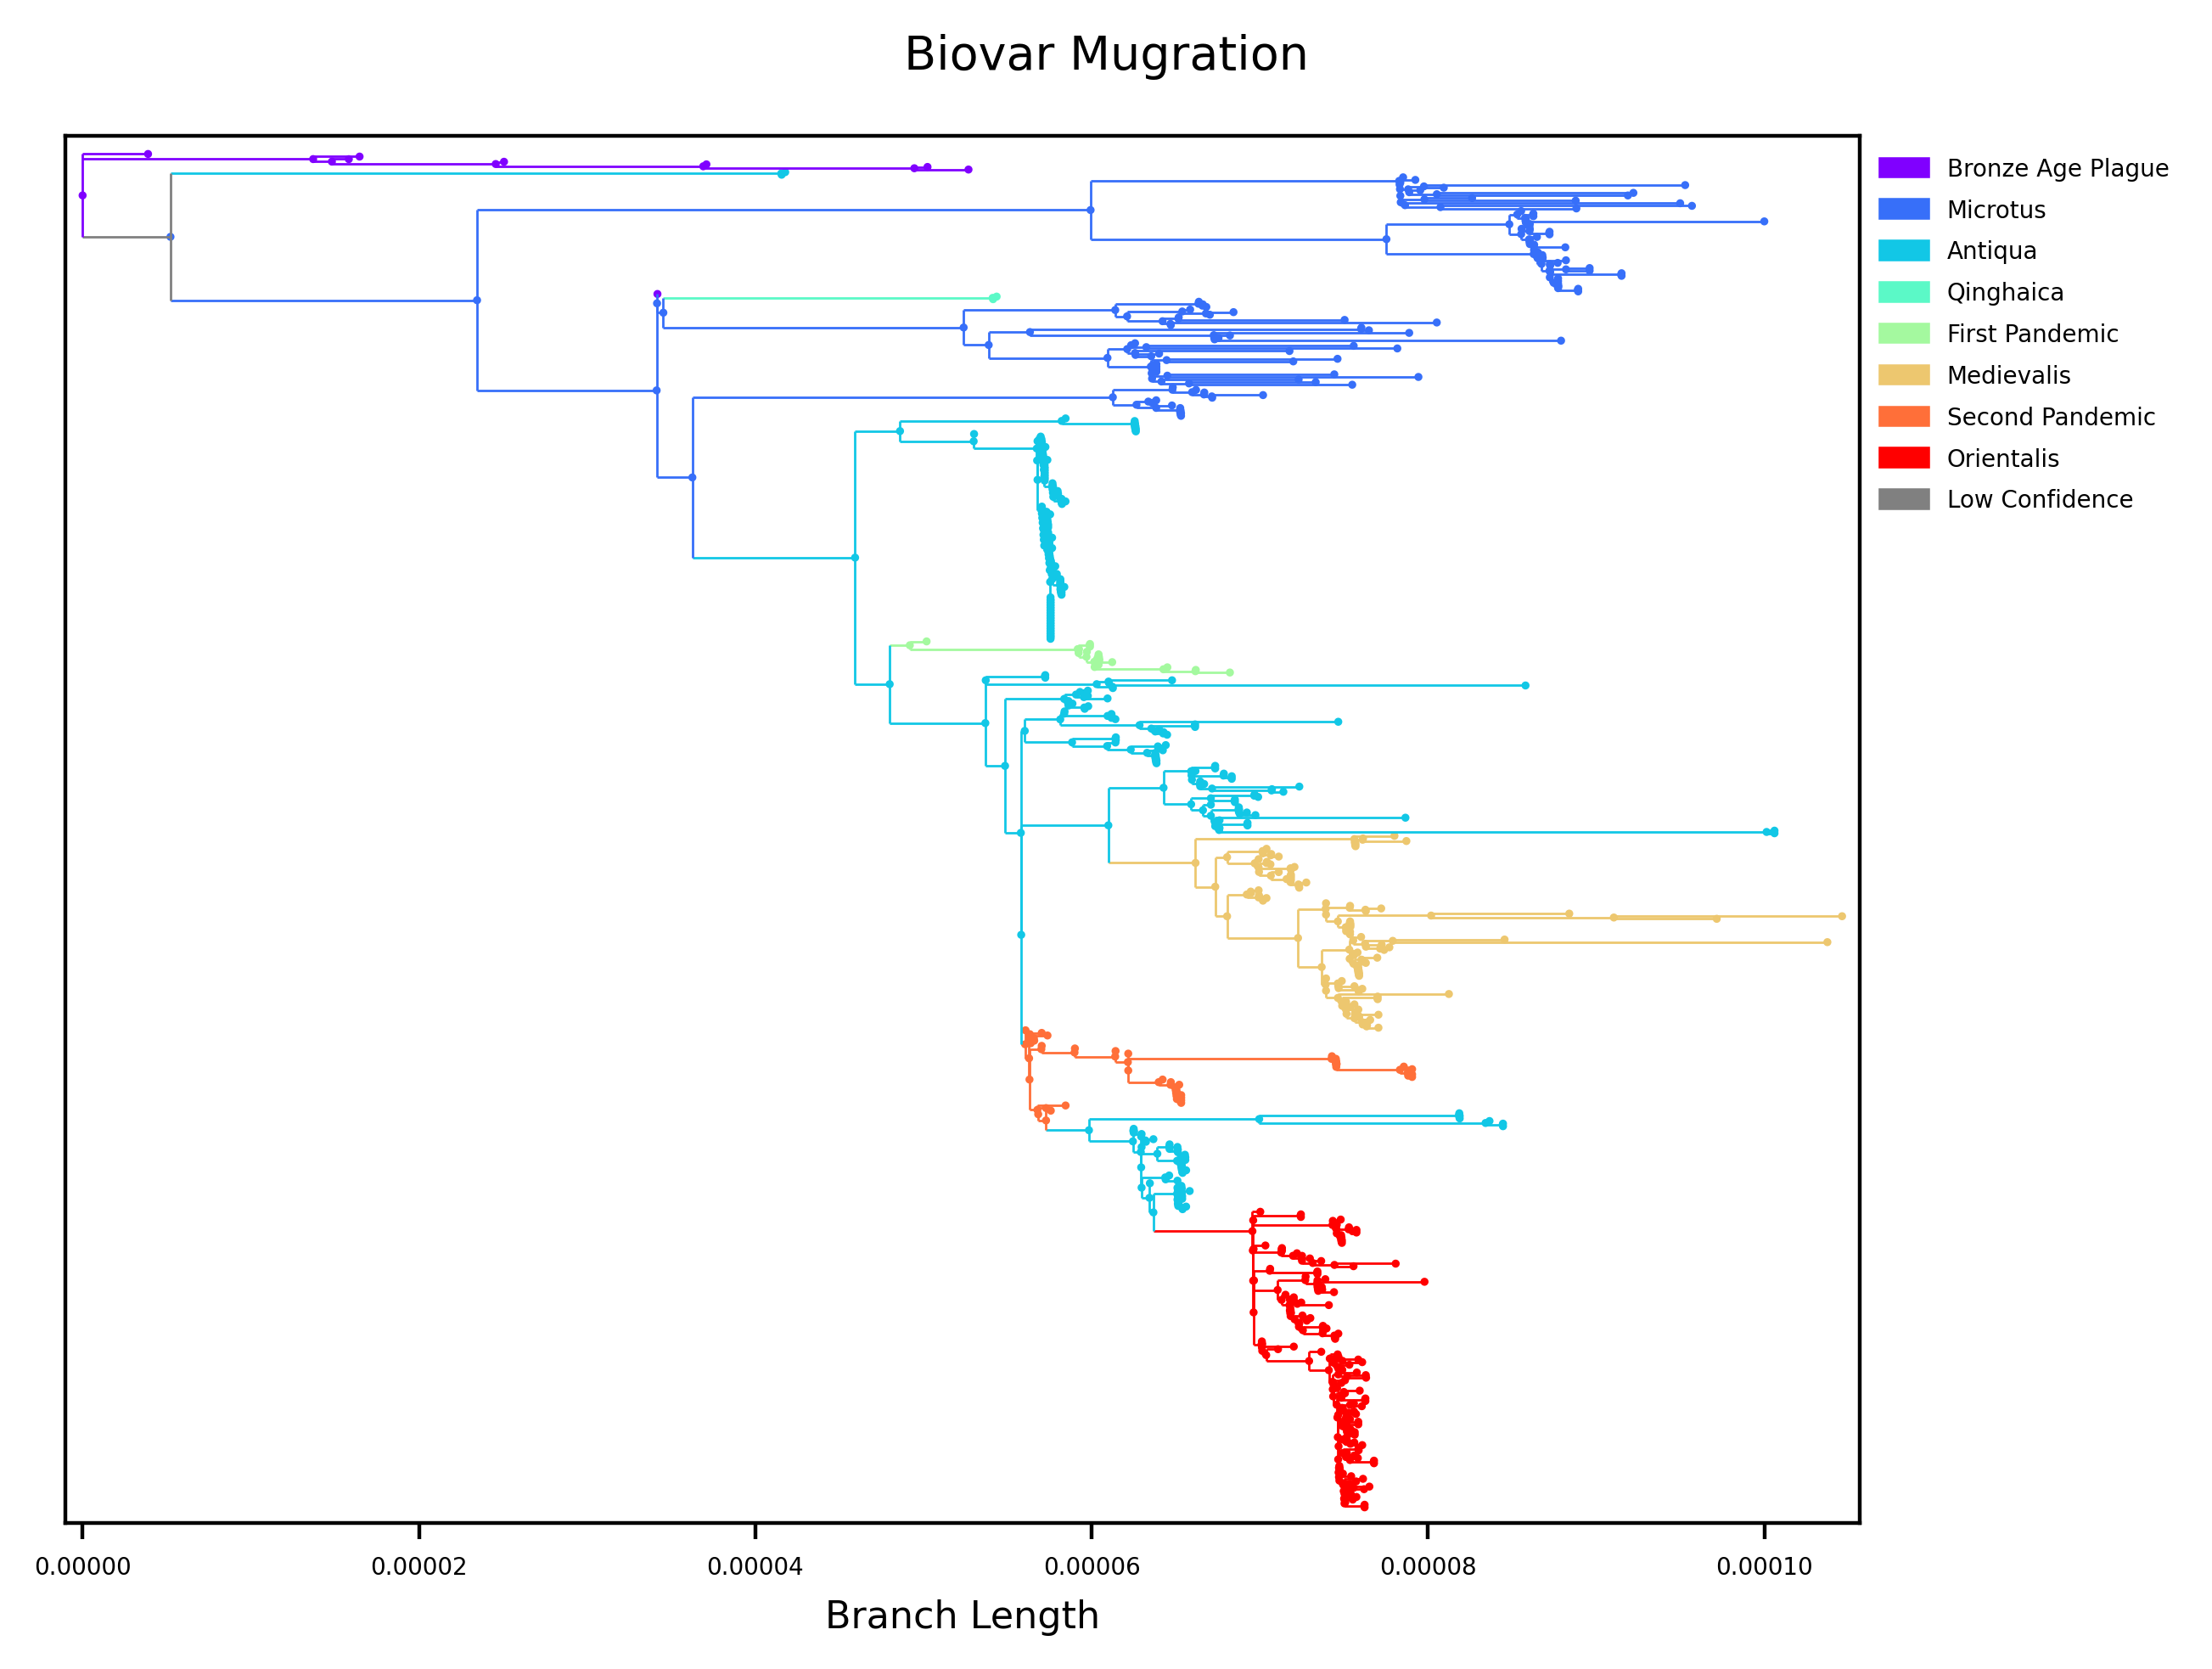

In [10]:
out_path_colors = os.path.join(outdir, SCRIPT_NAME + "_colors.tsv")
file_colors = open(out_path_colors, "w")

for attr in ATTRIBUTE_LIST:  
    # --------------------------------------------   
    # Canvas
    fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize, constrained_layout=True,)

    # --------------------------------------------
    # Color Tree
    hex_dict = color_tree(tree=tree_div, 
                          df=tree_df, 
                          attribute="Mugration_" + attr,
                          attribute_confidence="Mugration_" + attr + "_Confidence",
                          threshold_confidence=MUG_CONF_THRESH,                          
                          color_pal=CONT_COLOR_PAL)
    
    # Add the hex color dict to the dict
    mug_dict[attr]["hex_color"] = hex_dict  

    # Write to color file
    for state,color in hex_dict.items():
        file_colors.write(attr.lower() + "\t" + state + "\t" + color + "\n")    
        
    # Draw tree
    Phylo.draw(tree_div,
               axes=ax1, 
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)
    # --------------------------------------------
    # Draw tips
    colors = [mug_dict[attr]["hex_color"][state] for state in tree_df["Mugration_" + attr]]    
    ax1.scatter(data=tree_df, 
                x="coord_x", 
                y="coord_y", 
                s=0.5, 
                c=colors,
               )
    # --------------------------------------------
    # Ticks
    x_buffer = max(tree_df["coord_x"]) * 0.01
    y_buffer = math.ceil(len(tree_div.get_terminals()) * 0.01)   
    # --------------------------------------------
    # Limits
    ax1.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)    
    ax1.set_ylim(len(tree_div.get_terminals()) + y_buffer, 0 - y_buffer)
    ax1.set_yticks([])    
    # --------------------------------------------
    # Labels
    ax1.set_xlabel("Branch Length")
    ax1.set_ylabel("")
    fig.suptitle("{} Mugration".format(attr.replace("_"," ")))    
    # --------------------------------------------
    # Legend
    legend_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in mug_dict[attr]["hex_color"].values()]
    legend_labels = list(mug_dict[attr]["hex_color"].keys())
    ax1.legend(legend_elements, 
              legend_labels,
              bbox_to_anchor=(1.0, 1.0), 
              loc='upper left',
              frameon=False,
             )
    # --------------------------------------------
    # Export
    out_path = os.path.join(outdir, SCRIPT_NAME + "_tree_{}.{}".format(attr.lower(), FMT))  
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

file_colors.close()

---
## Export

### Save dataframe

In [11]:
# Save tree dataframe with mugration info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")